## The Classic Titanic Problem
#### Vikram Reddy

November 10, 2017

In [156]:
# Importing Modules

# Tables, Queries, and Stats
import pandas as pd
import numpy as np

# Plotting
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# Data Partitioning
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Decision Tree Model and Plotting
import warnings; warnings.simplefilter('ignore');
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# Ensemble Methods
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Error Analysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

## Part 1: Exploring the Titanic

Your mission for this problem set is to use your knowledge of supervised machine learning to try to predict which passengers aboard the Titanic were most likely to survive. The prompts for this part of the problem set are deliberately vague - the goal is to leave it up to you how to structure (most of) your analysis.

To get started, read about the prediction problem on [Kaggle](https://www.kaggle.com/c/titanic). Then, download the data [here](https://www.kaggle.com/c/titanic/data) - you'll want at least the train and test data, maybe more.

### 1.1 Exploratory data analysis

Create 2-3 figures and tables that help give you a feel for the data. Make sure to at least check the data type of each variable, to understand which variables have missing observations (and to formulate a plan for dealing with them), and to understand the distribution of each variable (and determine whether the variables should be normalized or not). Are any variables collinear or highly correlated?

In [157]:
data = pd.read_csv('train.csv')
features = data.copy().drop('Survived', axis=1, inplace=False)
labels = pd.DataFrame(data['Survived'], columns=['Survived'])

In [158]:
# First I split the train.csv data into train and test. I will do my EDA on the resulting train data.
train_features, test_features, train_labels, test_labels = train_test_split(features, labels,
                                                                            test_size=0.2,
                                                                            random_state=789
                                                                           )

#### Now I will proceed with the exploratary data analysis.

In [159]:
train_features.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [160]:
train_features.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
355,356,3,"Vanden Steen, Mr. Leo Peter",male,28.0,0,0,345783,9.5000,NaN,S
343,344,2,"Sedgwick, Mr. Charles Frederick Waddington",male,25.0,0,0,244361,13.0000,NaN,S
66,67,2,"Nye, Mrs. (Elizabeth Ramell)",female,29.0,0,0,C.A. 29395,10.5000,F33,S
753,754,3,"Jonkoff, Mr. Lalio",male,23.0,0,0,349204,7.8958,NaN,S
445,446,1,"Dodge, Master. Washington",male,4.0,0,2,33638,81.8583,A34,S


### Distribution of each variable

In [161]:
train_features.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,567.000000,712.000000,712.000000,712.000000
mean,438.178371,2.304775,29.812028,0.532303,0.405899,32.872307
std,256.132823,0.835957,14.507624,1.124623,0.843353,51.208730
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,212.750000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,436.500000,3.000000,28.000000,0.000000,0.000000,14.500000
75%,661.500000,3.000000,39.000000,1.000000,0.000000,31.303125
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


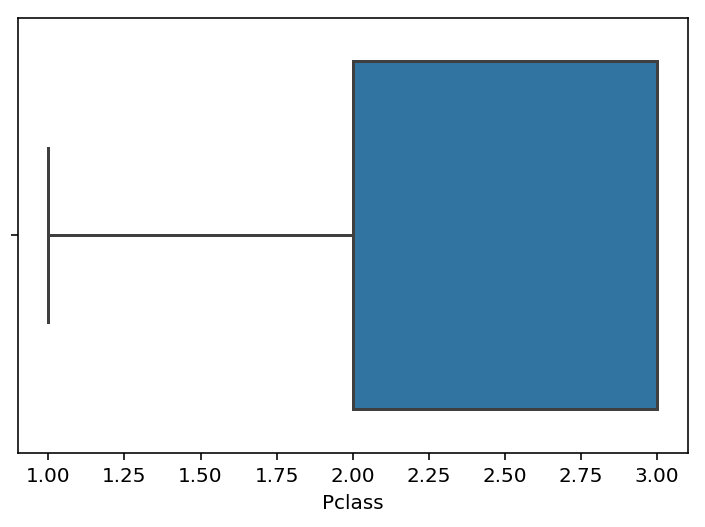

In [162]:
sns.boxplot(train_features['Pclass']);

This makes sense that most of the ship is in second or third class. Only a small amount of people are in 1st class.

In [163]:
train_features.groupby('Pclass').count()['PassengerId']

Pclass
1    173
2    149
3    390
Name: PassengerId, dtype: int64

Here I see that actually 2nd class has the least amount of people. Then comes 1st class. Third class has more people than 1st and 2nd class combined.

In [164]:
train_features.groupby('Pclass').mean()

,PassengerId,Age,SibSp,Parch,Fare
Pclass,,,,,
1,469.676301,38.059467,0.421965,0.358382,85.987525
2,428.577181,30.099496,0.436242,0.442953,20.760180
3,427.874359,25.218237,0.617949,0.412821,13.938395


### Null Counts in dataset

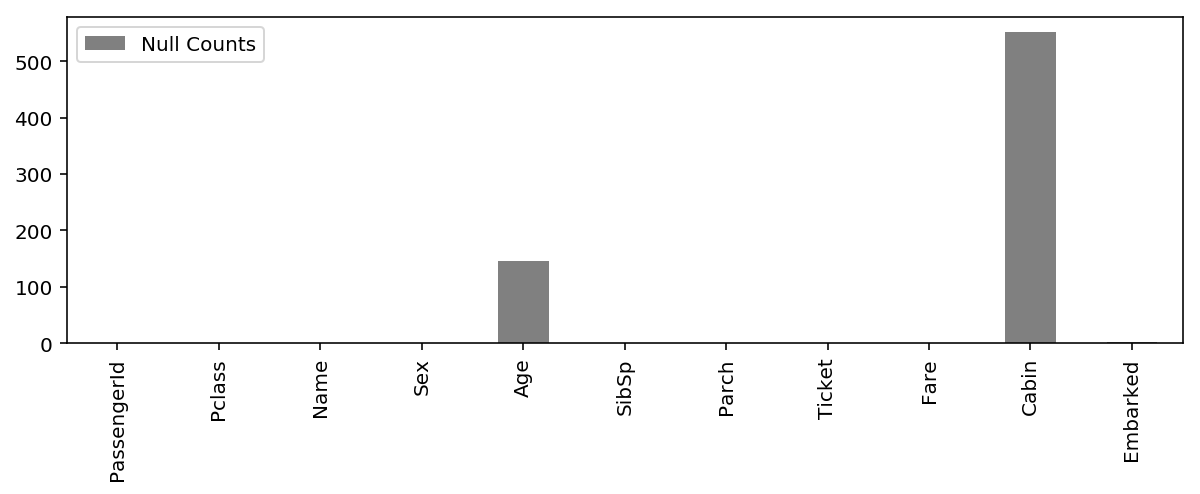

In [165]:
pd.DataFrame(train_features.isnull().sum(), columns=['Null Counts']).plot(kind='bar',
                                                                       figsize=(10,3),
                                                                       color='grey');

So Age and Cabin have Null values. I can fill these values either with zeros or with the median value in that column. 

### Distributions of each variable

### 1.2 Correlates of survival

Use whatever methods you can think of to try and figure out what factors seem to determine whether or not a person would survive the sinking of the Titanic. What do you conclude?

In [166]:
# Preprocessing
def fill_nans_zeros(df):
    df = df.fillna(0)
    return df

def fill_nans_median(df):
    df = df.fillna(df.median())
    return df

def expand_cabin(df):
    # Dummy variablize the cabin vars
    df_cabin_vars = pd.get_dummies(df['Cabin'])
    df[df_cabin_vars.columns] = df_cabin_vars
    #df = df.drop('Cabin', axis=1, inplace=False)
    return df

# Build Preprocessed dataset
def preprocess_dataset(df):
    # fill quantitative vars with median
    #df = fill_nans_median(df)
    # Dummy variablize Cabin to eliminate NaNs in Categorical variable
    #df = expand_cabin(df)
    return df

In [167]:
train_features_new = preprocess_dataset(train_features)

In [168]:
#print([x for x in train_features_new.columns])

Preliminary Observations: I made each of the unique cabin names into separate features. This was to eliminate the NaN values in the Cabin column.

I may further group the cabins into A, B, C, D, etc. and use that grouping as a feature

Next, I put used the median value of Age to fill in the NaNs in the age column.

Below I will explore further features that result beyond the initial preprocessing of the data. These are features such as First Name, Last Name, Title, etc.

In [169]:
# Feature Engineering:

# First Name:
def get_first_name(df):
    # This one needs some work
    df['First_name'] = df['Name'].apply(lambda x: ' '.join(x.split(',')[1].split()[1:]))
    return df

# Last Name:
def get_last_name(df):
    df['Last_name'] = df['Name'].apply(lambda x: x.split(',')[0])
    return df

# Title:
def get_title(df):
    df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split()[0])
    return df

def get_cabin_floor(df):
    df['Cabin_floor'] = df['Cabin'].apply(lambda x: str(x)[0] if str(x) != 'nan' else 'Undefined_cabin')
    df_cabin_floors = pd.get_dummies(df['Cabin_floor'])
    df[df_cabin_floors.columns] = df_cabin_floors
    df = df.drop('Cabin_floor', axis=1, inplace=False)
    df = df.drop('Cabin', axis=1, inplace=False)
    #print(df_cabin_floors.columns)
    return df

def make_one_hots(df, categorical_vars):
    ''' Make one-hot vectors for the following features:
    Pclass, Last_name, Sex.
    Keep the original columns for now.
    '''
    df_new = df.copy()
    for feature in categorical_vars:
        dummies = pd.get_dummies(df[feature])
        if feature == 'Pclass':
            column_names = ['1st_class','2nd_class','3rd_class']
            df_new[column_names] = dummies
        else:
            df_new[dummies.columns] = dummies
        #print(feature, dummies.columns)
    return df_new

def fill_in_median_val(x, column_name, measure_by_class):
    '''Fill in a column name using the class, sex and title measures.'''
    if np.isnan(x[column_name]):
        x[column_name] = measure_by_class[x['Pclass']]
    
    return x

def build_featureset(df, categorical_vars):
    df = preprocess_dataset(df)
    #df = get_first_name(df)
    df = get_last_name(df)
    df = get_title(df)
    df = get_cabin_floor(df)
    df = make_one_hots(df, categorical_vars)
    
    # Fill medians based on Sex, Pclass, Title bins
    #age_by_class = df.groupby(['Sex','Pclass','Title'])['Age'].median()
    median_age_by_class = df.groupby(['Pclass'])['Age'].median()
    median_fare_by_class = df.groupby(['Pclass'])['Fare'].median()
    df = df.apply(lambda x: fill_in_median_val(x, 'Age', median_age_by_class), axis=1)
    df = df.apply(lambda x: fill_in_median_val(x, 'Fare', median_age_by_class), axis=1)
    return df


In [170]:
# train_features_new = build_featureset(train_features, ['Pclass', 'Sex', 'Title','Embarked']);

In [171]:
categorical_vars = ['Pclass', 'Sex', 'Title', 'Last_name','Embarked']
train_features_new = build_featureset(train_features, categorical_vars)

*Enter your observations here*

## Part 2: Decision Trees

... Because how can you take a course in Applied Machine Learning without fitting a decision tree?

In [172]:
def dropping_columns(df, columns=None):
    ''' Dropping string-valued columns, preprocessing for Decision Tree
    '''
    df = df.drop(columns, axis=1, inplace=False)
    return df

In [173]:
# train_features_final = dropping_columns(train_features_new, columns=['Sex','Title','Pclass', 
#                 'Embarked', 'PassengerId'
#                  , 'Ticket', 'Name'])

In [174]:
# If I include last name
train_features_final = dropping_columns(train_features_new, columns=['Sex','Title',
'Pclass', 'Embarked', 'PassengerId'
                 , 'Last_name', 'Ticket', 'Name'])

In [175]:
# Create test features:
test_features_new = build_featureset(test_features, categorical_vars)

In [176]:
#No Last Name
# test_features_final = dropping_columns(test_features_new, columns=['Sex','Title',
#                 'Pclass', 'Embarked', 'PassengerId'
#                  , 'Ticket', 'Name'])

In [177]:
# Last Name
test_features_final = dropping_columns(test_features_new, columns=['Sex','Title',
                'Pclass', 'Embarked', 'PassengerId'
                 , 'Ticket', 'Name', 'Last_name'])

In [178]:
def trim_featuresets(train_features, test_features):
    for col in train_features.columns:
        if col not in test_features.columns:
            train_features = train_features.drop([col], axis=1, inplace=False)
    for col in test_features.columns:
        if col not in train_features.columns:
            test_features = test_features.drop([col], axis=1, inplace=False)
    return train_features, test_features

In [179]:
train_features_final, test_features_final = trim_featuresets(
        train_features_final,
        test_features_final)

In [180]:
train_features.shape

(712, 23)

In [181]:
test_features.shape

(179, 21)

In [182]:
def run_model(model, train_features, train_labels, test_features, test_labels, verbose=True):
    if verbose:
        print()
        print('Training the model (Fitting to the training data) ')
    fitted = model.fit(train_features, train_labels)
    if verbose:
        print('Fitted model: {}'.format(fitted))
        print('Test the model.')
    predicted = fitted.predict(test_features)
    predicted_classes = predicted.round()
    accuracy = accuracy_score(predicted_classes, test_labels)
    #fscore = f1_score(predicted_classes, test_labels, average='weighted')
    if verbose:
        print('This model\'s accuracy is {}'.format(accuracy))
    #print('This model\'s f1 score is {}'.format(fscore))
    return fitted, accuracy

def decision_tree(max_leaf_nodes=10, max_depth=None):
    return run_model(DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, max_depth=max_depth), 
                     train_features_final,
                    train_labels, test_features_final, test_labels)


In [183]:
dt_classifier, accuracy_dt = decision_tree()


Training the model (Fitting to the training data) 
Fitted model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=10, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Test the model.
This model's accuracy is 0.8324022346368715


In [184]:
train_features_final.shape

(712, 75)

In [185]:
test_features_final.shape

(179, 75)

### 2.1 Decision Tree
Using the basic [Decision Tree](http://scikit-learn.org/stable/modules/tree.html#tree) library in sklearn, fit a model to predict titanic survival. Make sure you come up with an appropriate way of handling each of the input variables before feeding them in to the decision tree. You can use the [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) method to implement 10-fold cross-validation. Report the average training and testing accuracy across your 10 folds, and show a diagram of the tree (at least the first three levels).


In [186]:
from sklearn import tree
# Enter your code here

In [187]:
from sklearn.model_selection import KFold
# your code here
def cv_dt(max_leaf_nodes=10, verbose=True):
    kf = KFold(n_splits=10, random_state=789, shuffle=False)
    train_arr = np.asarray(train_features_final)
    test_arr = np.asarray(test_features_final)
    test_labels_arr = np.asarray(test_labels)
    train_labels_arr = np.asarray(train_labels)
    test_accuracies = []
    train_accuracies = []
    fold = 0
    folds = []
    best_fitted_tree = None
    fitted_trees = []
    
    for train_index, test_index in kf.split(train_arr):
        fold += 1
        folds.append(fold)
        train_features, test_features = train_arr[train_index], train_arr[test_index]
        
        train_label, test_label = train_labels_arr[train_index], train_labels_arr[test_index]
        # Run Cross-Validation here
        # lin_reg = LinearRegression()
        test_fitted, test_accuracy = run_model(DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes), train_features,
                    train_label, test_features, test_label, verbose=verbose)
        train_fitted, train_accuracy = run_model(DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes), train_features,
                    train_label, train_features, train_label, verbose=verbose)
        fitted_trees.append(train_fitted)
        test_accuracies.append(test_accuracy)
        train_accuracies.append(train_accuracy)
    avg_train_accuracy = np.mean(train_accuracies)
    avg_test_accuracy = np.mean(test_accuracies)
    max_test_accuracy = max(test_accuracies)
    index_of_best_tree = test_accuracies.index(max_test_accuracy)
    best_fitted_tree = fitted_trees[index_of_best_tree]
    print('Average training accuracy is {}'.format(avg_train_accuracy))
    print('Average test accuracy is {}'.format(avg_test_accuracy))
    return avg_train_accuracy, avg_test_accuracy, best_fitted_tree

### Overfitting the decision tree on Training

In [188]:
_,_, dt_overfit = cv_dt(max_leaf_nodes=None, verbose=False)

Average training accuracy is 0.9906364567082683
Average test accuracy is 0.7836267605633804


In [189]:
#cv_dt(max_leaf_nodes=10, verbose=False)

In [190]:
# Put the fitted model of the best test accuracy on cv set
# dot_data = StringIO()
# export_graphviz(tree_titanic, out_file=dot_data,  
#                filled=True, rounded=True,
#                special_characters=True,
#                max_depth=3)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())
# I used the pydotplus library

In [191]:
feature_names = train_features_final.columns
label_names = pd.DataFrame(train_labels, columns=['Survived']).columns
dot_data = export_graphviz(dt_overfit, out_file=None,
               feature_names=feature_names,
               # Below are the Survived class names
               class_names=['Died','Survived'],
               filled=True, rounded=True,
               special_characters=False,
                max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data)

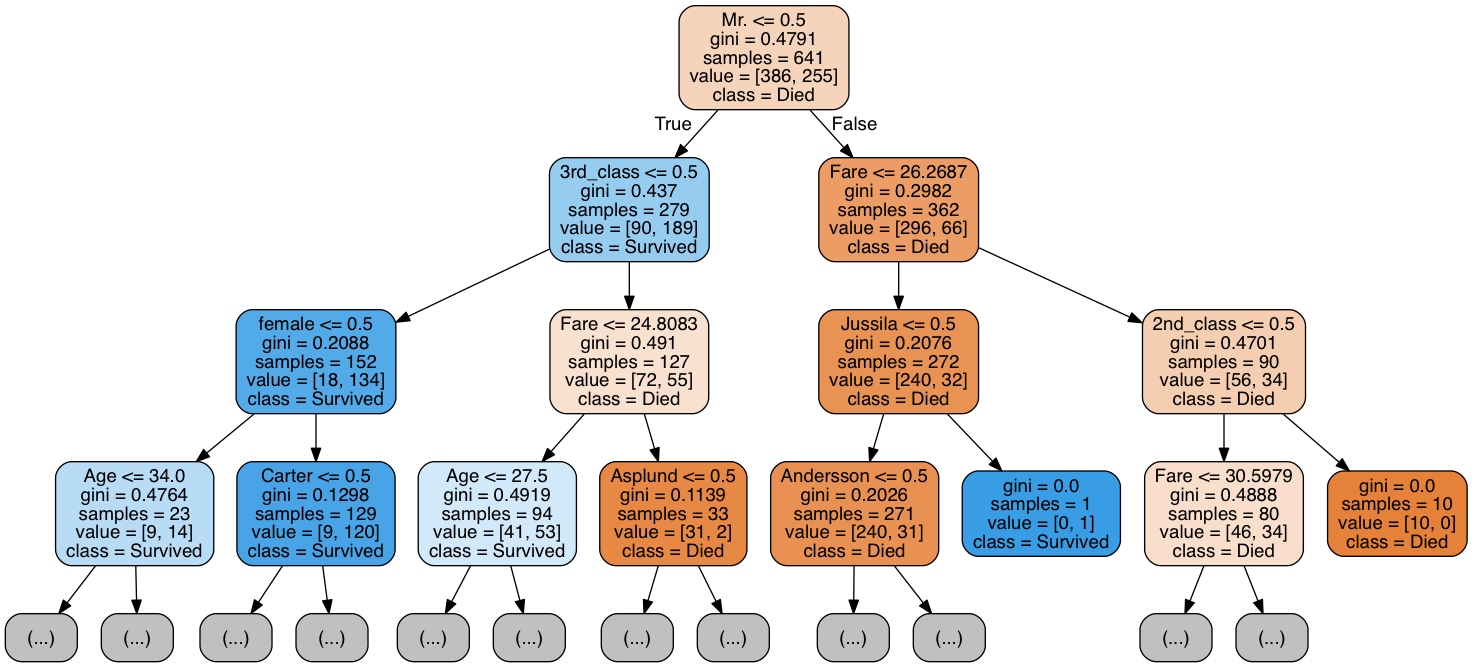

In [192]:
Image(graph.create_png())

I overfit the training set, so my training accuracy is very high, but my test accuracy is lower (train = 99.1%, test = 79.3%). I overfit the training set because I allowed the tree to perfectly classify every point in the training set. It created an expansive set of rules that covers every training point. These rules may not generalize to points in the test set.

### 2.2 Tree tuning

Use all of the data to re-fit a single decision tree with max_depth = 4 (i.e., no cross-validation). Show the tree diagram and also plot the feature importances. What do you observe?

In [193]:
# Enter your code here
dt_classifier, accuracy_four_nodes = decision_tree(max_leaf_nodes=None, max_depth=4)


Training the model (Fitting to the training data) 
Fitted model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Test the model.
This model's accuracy is 0.8324022346368715


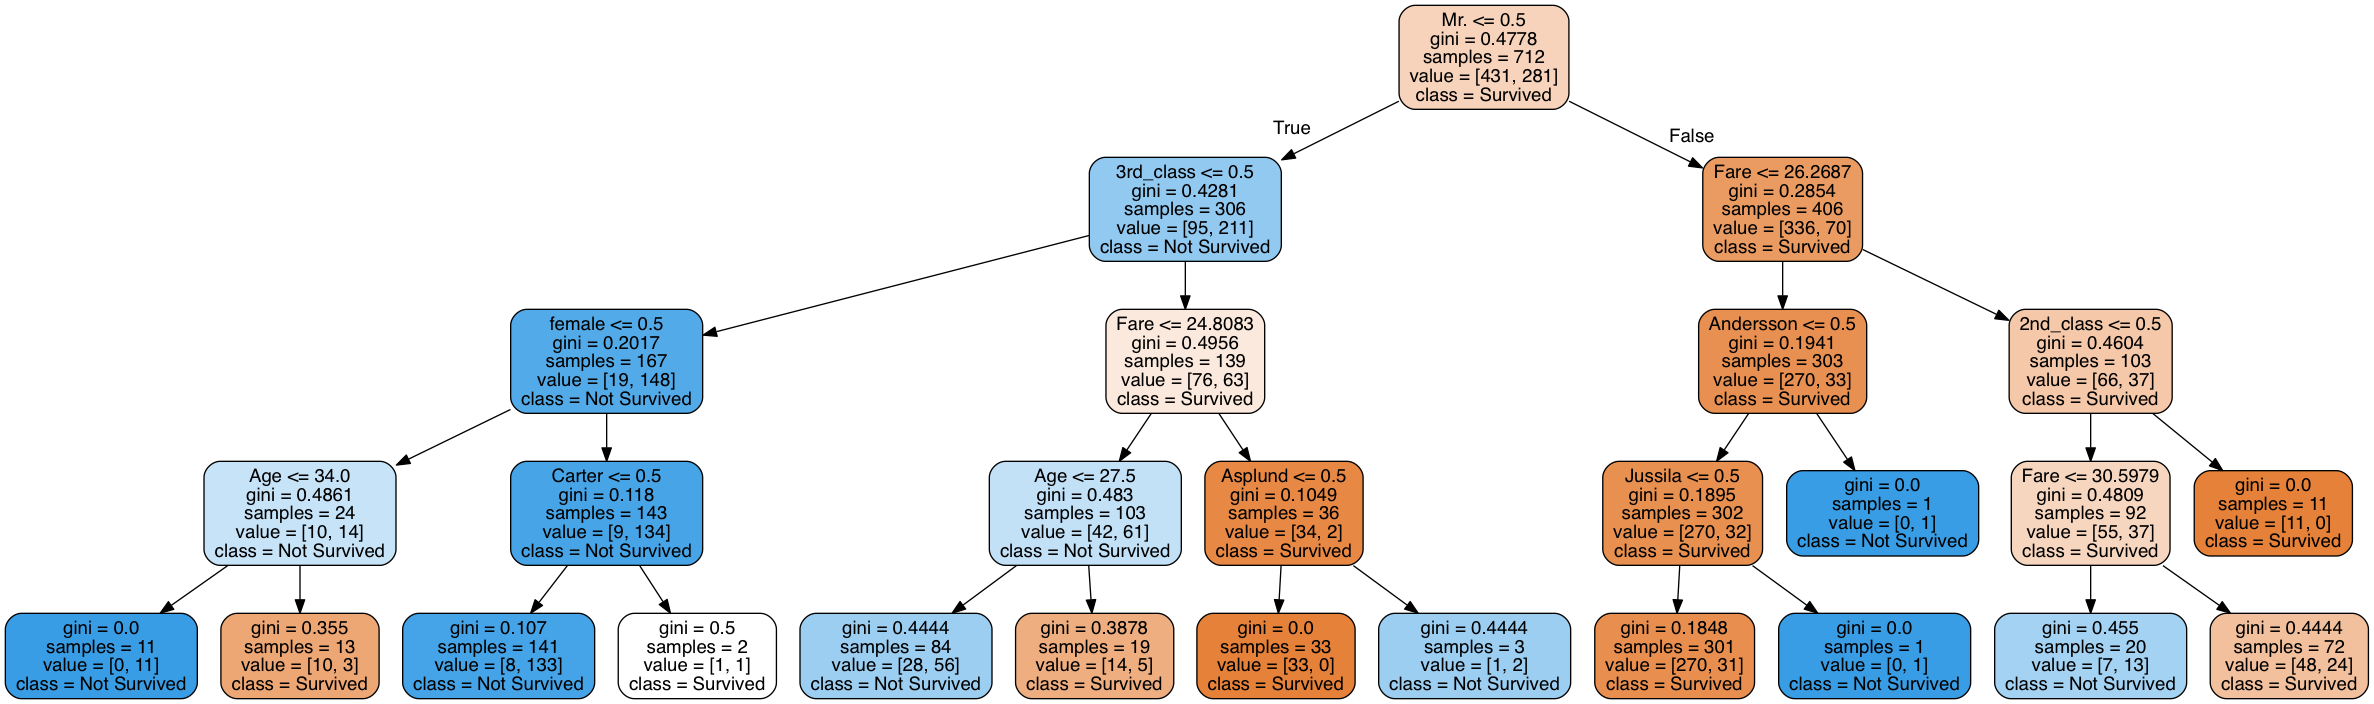

In [194]:
feature_names = train_features_final.columns
label_names = pd.DataFrame(train_labels, columns=['Survived']).columns
dot_data = export_graphviz(dt_classifier, out_file=None,
               feature_names=feature_names,
               # Below are the Vehicle Type classes
               class_names=['Survived','Not Survived'],
               filled=True, rounded=True,
               special_characters=False)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [195]:
df_importance = pd.DataFrame(list(zip(train_features_final.columns, dt_classifier.feature_importances_)),
            columns=['name', 'importance'])


In [196]:
def plot_importance(df_importance):
    fig, ax = plt.subplots(figsize=(25,4))
    sns.barplot('name','importance', data=df_importance)
    x = train_features_final.columns
    ax.set_xticks(list(range(0,len(x))))

    ax.set_xticklabels(x, rotation=45, ha='right', fontsize=8)

    ax.set_ylabel('Importance', fontsize=16, color='blue')
    ax.set_xlabel('Feature', fontsize=16, color='blue')

    ax.set_title('Feature vs. Importance', fontsize=16, color='blue')
    ax.tick_params(labelsize=14, labelcolor='black')
    # Take out right and top axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

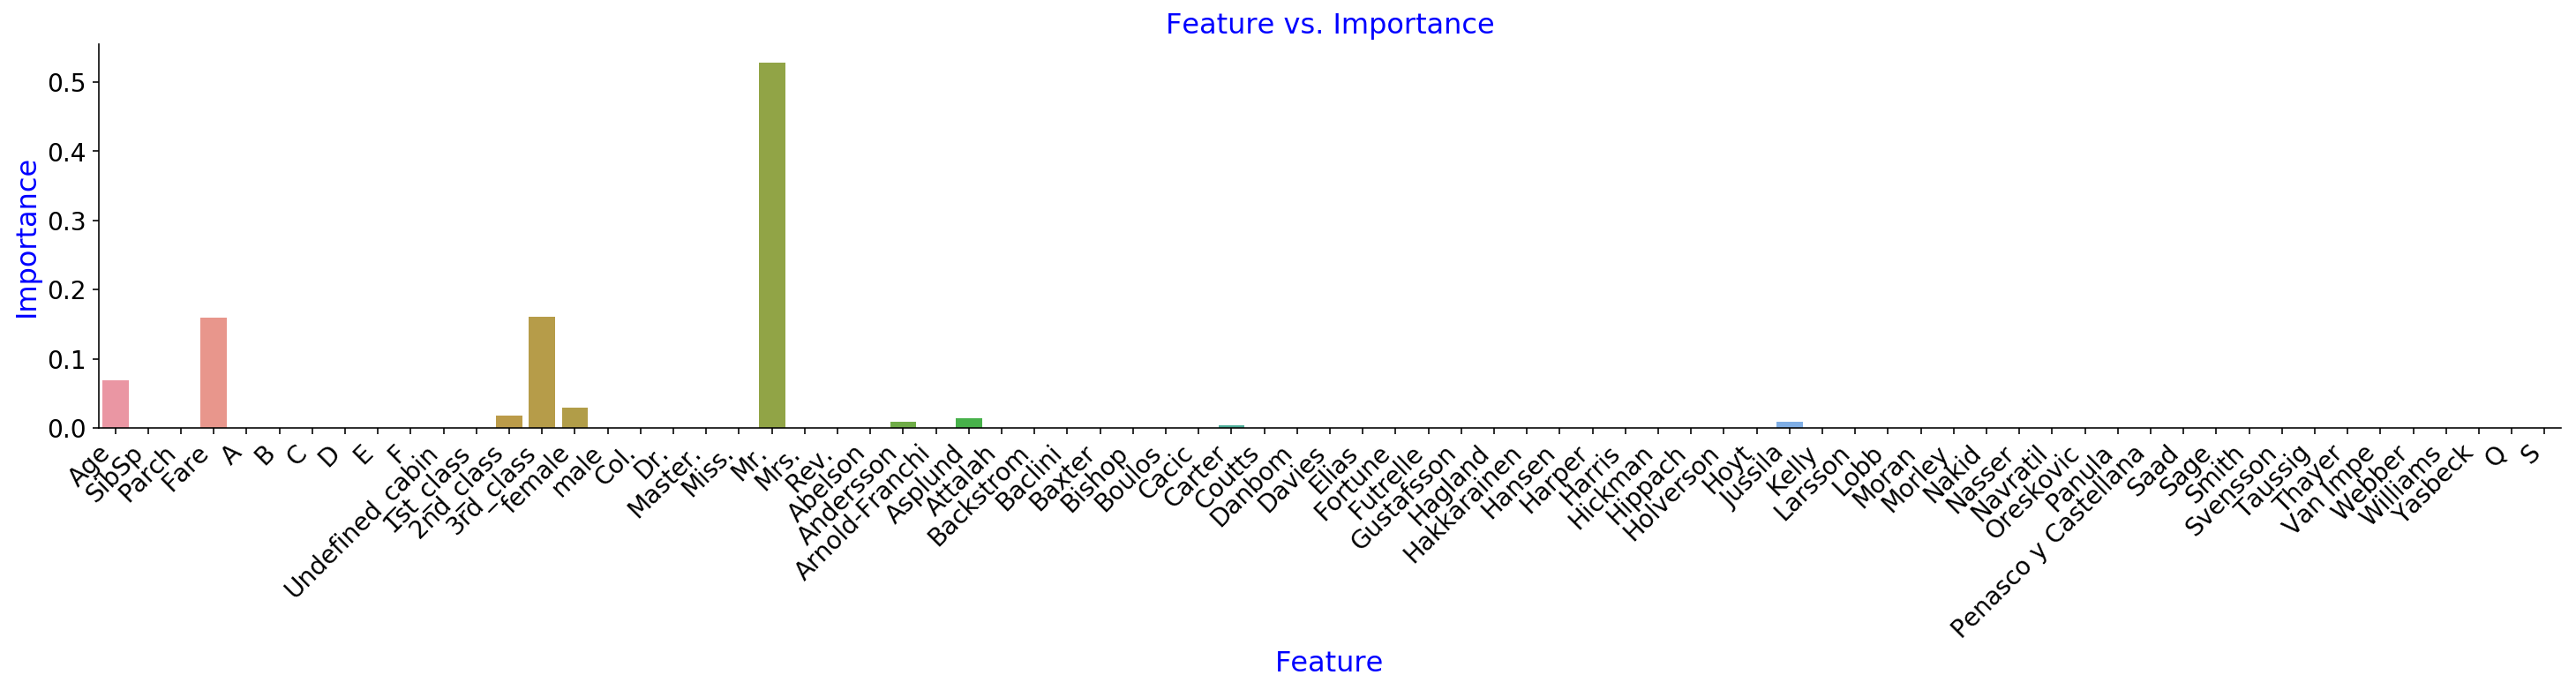

In [197]:
plot_importance(df_importance)

First of all, notice I have increased test set accuracy, 83%. This is because I am no longer overfitting the training set. Instead, I prune the tree to a maximum depth of 4, which can generalize better for data points in the test set.

** Feature importance Observations **

Decision Trees greedily split on purity of the Gini coefficient, so the resulting feature importance would be biased towards features that yield high purity after the split. The features that do not result in splits have no weightage in the model. 

Thus, the feature importance in the decision tree is directly related to the number of nodes and the max_depth of the tree. Since I have set the max_depth to 4, this limited the amount of features that could appear in the tree's splits. Therefore, most of the features in the dataset by zero for their importance weightage.

'Mr' is the first split, so it is the highest in feature importance. Next comes 3rd class, then Fare, and finally Age. 

### 2.3 Sensitivity analysis
The built-in algorithm you are using has several parameters which you can tune. Using cross-validation, show how the choice of these parameters affects performance.

First, show how max_depth affects train and test accuracy. On a single axis, plot train and test accuracy as a function of max_depth. Use a red line to show test accuracy and a blue line to show train accuracy.

Second, show how test accuracy relates to both max_depth and min_samples_leaf. Specifically, create a 3-D plot where the x-axis is max_depth, the y-axis is min_samples_leaf, and the z-axis shows accuracy. What combination of max_depth and min-samples_leaf achieves the highest accuracy? How sensitive are the results to these two parameters?

In [198]:
def cv_dt_sensitivity(max_depth=4, min_samples_leaf=20, verbose=True):
    kf = KFold(n_splits=10, random_state=789, shuffle=False)
    train_arr = np.asarray(train_features_final)
    test_arr = np.asarray(test_features_final)
    test_labels_arr = np.asarray(test_labels)
    train_labels_arr = np.asarray(train_labels)
    test_accuracies = []
    train_accuracies = []
    fold = 0
    folds = []
    for train_index, test_index in kf.split(train_arr):
        fold += 1
        folds.append(fold)
        train_features, test_features = train_arr[train_index], train_arr[test_index]
        
        train_label, test_label = train_labels_arr[train_index], train_labels_arr[test_index]
        # Run Cross-Validation here
        # lin_reg = LinearRegression()
        test_fitted, test_accuracy = run_model(DecisionTreeClassifier(max_depth=max_depth,
                                                                      min_samples_leaf=min_samples_leaf), 
                                                                    train_features,
                                                                    train_label, test_features, 
                                                                    test_label, verbose=verbose)
        train_fitted, train_accuracy = run_model(DecisionTreeClassifier(max_depth=max_depth,
                                                                      min_samples_leaf=min_samples_leaf), 
                                                                    train_features,
                                                                    train_label, train_features, 
                                                                    train_label, verbose=verbose)
        test_accuracies.append(test_accuracy)
        train_accuracies.append(train_accuracy)
    avg_train_accuracy = np.mean(train_accuracies)
    avg_test_accuracy = np.mean(test_accuracies)
    print('Average training accuracy is {}'.format(avg_train_accuracy))
    print('Average test accuracy is {}'.format(avg_test_accuracy))
    return avg_train_accuracy, avg_test_accuracy

In [199]:
import matplotlib.patches as mpatches

In [200]:
def f_of_max_depth(max_depth_list, min_samples_leaf=1):
    train_accuracies = []
    test_accuracies = []
    for max_depth in max_depth_list:
        avg_train_accuracy, avg_test_accuracy = cv_dt_sensitivity(max_depth=max_depth,
                                                      min_samples_leaf=min_samples_leaf,
                                                     verbose=False)
        train_accuracies.append(avg_train_accuracy)
        test_accuracies.append(avg_test_accuracy)
    return train_accuracies, test_accuracies

def f_of_max_depth_and_min_samples_leaf(max_depth_list, min_samples_leaf_list):
    train_accuracies = []
    test_accuracies = []
    for max_depth, min_samples_leaf in list(zip(max_depth_list, min_samples_leaf_list)):
        avg_train_accuracy, avg_test_accuracy = cv_dt_sensitivity(max_depth=max_depth,
                                                     min_samples_leaf=min_samples_leaf,
                                                     verbose=False)
        test_accuracies.append(avg_test_accuracy)
    return test_accuracies

def plot_max_depth_vs_train_test(max_depth_list):
    train_accuracies, test_accuracies = f_of_max_depth(max_depth_list)
    fig, ax = plt.subplots(figsize=(13,10))
    ax.set_title('Max Depth vs. Accuracy',
             fontsize=18,
             color='g',
             alpha=0.8)
    ax.set_xlabel('Max Depth', fontsize=16, color='g')
    ax.set_ylabel('Accuracy', fontsize=16, color='g')
    train_plot = ax.plot(max_depth_list, train_accuracies, color='b', marker='o')
    test_plot = ax.plot(max_depth_list, test_accuracies, color='r', marker='o')
    red_patch = mpatches.Patch(color='red', label='test accuracy')
    blue_patch = mpatches.Patch(color='blue', label='train accuracy')
    ax.legend(handles=[red_patch, blue_patch], loc='upper left', fontsize=14)
    # Take out right and top axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

Average training accuracy is 0.7854248732449298
Average test accuracy is 0.7794796557120501
Average training accuracy is 0.8172608716848673
Average test accuracy is 0.7935250391236306
Average training accuracy is 0.8428522328393135
Average test accuracy is 0.8187597809076681
Average training accuracy is 0.8528405323712949
Average test accuracy is 0.796283255086072


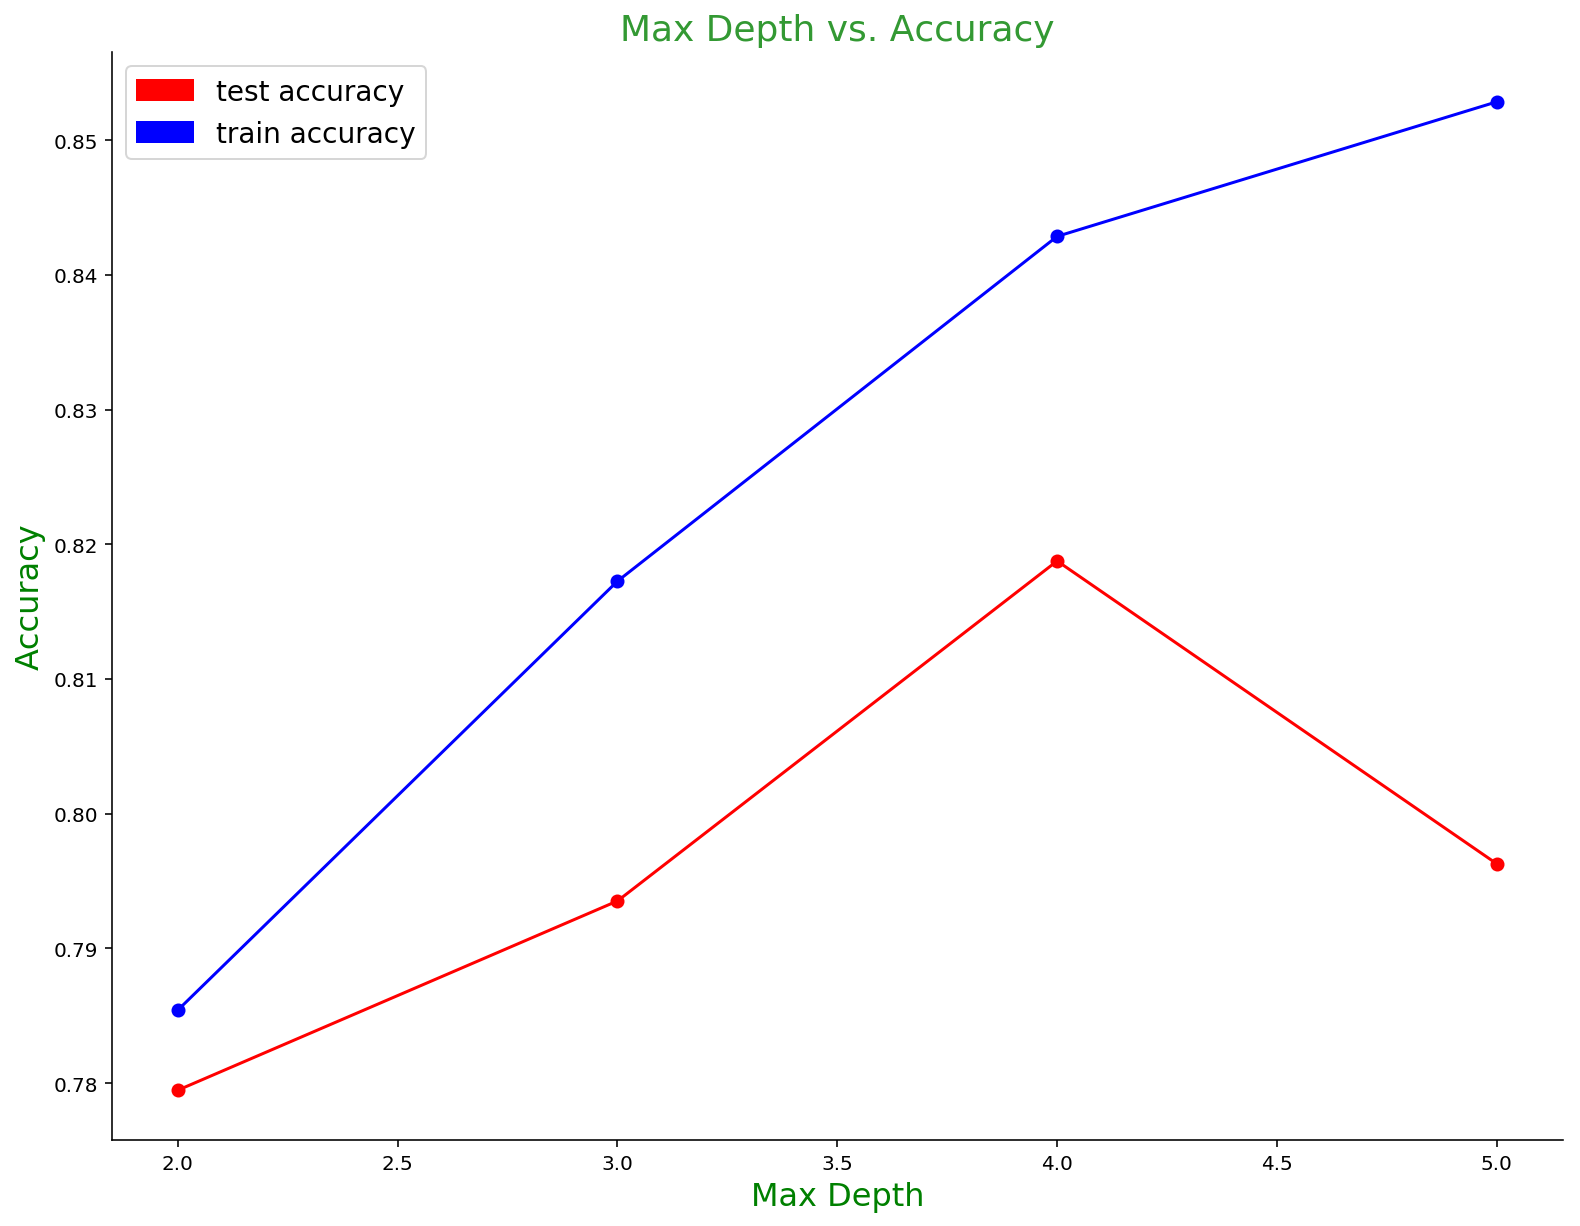

In [201]:
plot_max_depth_vs_train_test([2,3,4,5])

In [202]:
%config InlineBackend.figure_format='retina'

In [203]:
from mpl_toolkits.mplot3d import Axes3D

def plot_max_depth_and_min_samples_leaf_vs_train_test(max_depth_list, min_samples_leaf_list):
    test_accuracies = f_of_max_depth_and_min_samples_leaf(max_depth_list, 
                                                          min_samples_leaf_list)
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_title('Max Depth and Min Samples Leaf vs. Accuracy',
             fontsize=18,
             color='g',
             alpha=0.8)
    ax.set_xlabel('Max Depth', fontsize=12, color='g')
    ax.set_ylabel('Min Samples per Leaf', fontsize=12, color='g')
    ax.set_zlabel('Test_Accuracy', fontsize=12, color='g')
    test_plot = ax.plot(xs=max_depth_list, ys=min_samples_leaf_list, zs=test_accuracies,
                       color='red')
    red_patch = mpatches.Patch(color='red', label='test accuracy')
    ax.legend(handles=[red_patch], loc='upper right', fontsize=14)
    
    # Take out right and top axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

Average training accuracy is 0.7854248732449298
Average test accuracy is 0.7794796557120501
Average training accuracy is 0.8124227281591263
Average test accuracy is 0.79070813771518
Average training accuracy is 0.8164791341653667
Average test accuracy is 0.7794209702660406
Average training accuracy is 0.8121112031981278
Average test accuracy is 0.7836658841940531


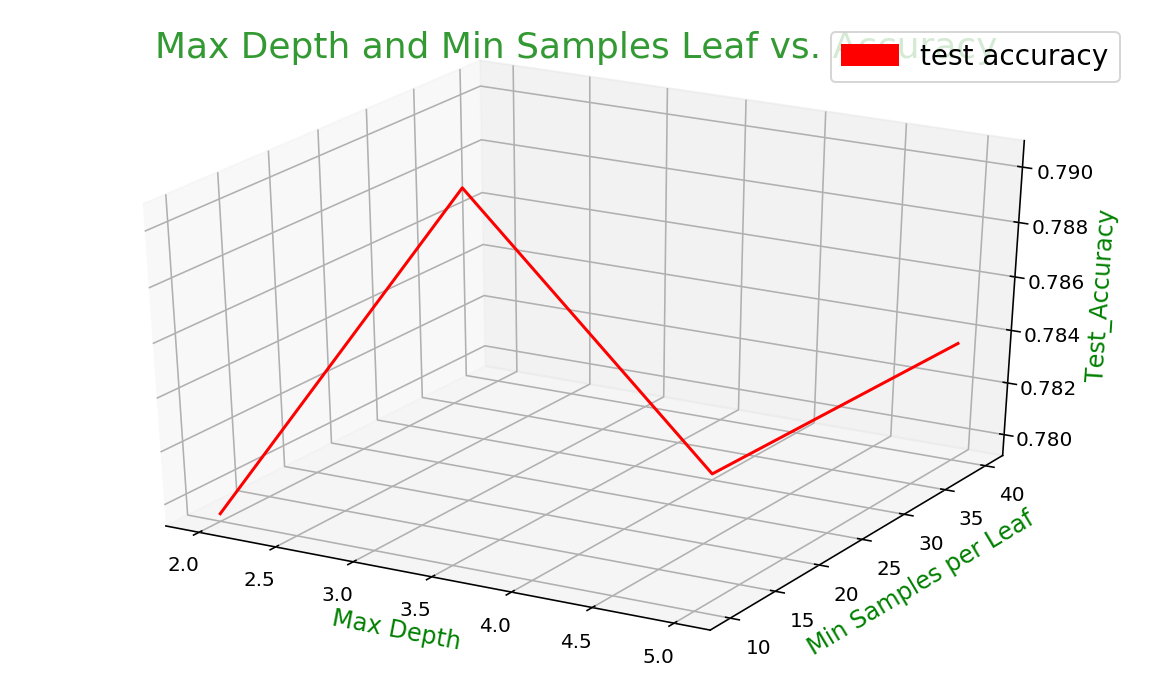

In [204]:
max_depth_list = [2,3,4,5]
min_samples_leaf_list = [10, 20, 30, 40]
plot_max_depth_and_min_samples_leaf_vs_train_test(max_depth_list, min_samples_leaf_list)

**Analysis of Accuracy vs. Max_Depth Plot:**

This makes sense because there is a tradeoff between max_depth and variance. As max_depth increases initially, bias decreases, so test accuracy increases. The decrease in bias overcomes the increase in variance. However, after some point the bias no longer decreases and variance becomes too high. The is the case of overfitting. Thus, training accuracy always increases because I am overfitting the training set. After a max_depth of 4, my test accuracy decreases.

**Analysis of Accuracy vs. Max_Depth and Min_samples_leaf Plot:**

As you can see in the graph above (although sparse), the lower the min samples per Leaf, the more the model overfits, which leads to a lower test accuracy. Similarly, as the max_depth increases, the model overfits. **The optimal level is reached at max_depth=3 and min_samples_leaf=20.** Here, the train accuracy is around 0.787.


### 2.4 Logistic Regression, for comparison
Use a 10-fold cross-validated logistic regression predict survival. Make sure you come up with an appropriate way of handling each of the input variables before feeding them in to the regression. 
* How does the performance of this model compare to the decision tree?
* How do the coefficients from the logistic regression compare to the feature importances from the decision tree? Create a scatter plot that shows this relationship (one dot for each variable, y-axis is feature importance, x-axis is....?)

In [205]:
# Enter your code here
def cv_dt_logreg():
    kf = KFold(n_splits=10, random_state=789, shuffle=False)
    train_arr = np.asarray(train_features_final)
    test_arr = np.asarray(test_features_final)
    test_labels_arr = np.asarray(test_labels)
    train_labels_arr = np.asarray(train_labels)
    test_accuracies = []
    train_accuracies = []
    fold = 0
    folds = []
    slopes = []
    for train_index, test_index in kf.split(train_arr):
        fold += 1
        folds.append(fold)
        train_features, test_features = train_arr[train_index], train_arr[test_index]
        train_label, test_label = train_labels_arr[train_index], train_labels_arr[test_index]
        # Run Cross-Validation here
        # lin_reg = LinearRegression()
        log_reg = LogisticRegression()
        fitted_log_reg = log_reg.fit(train_features, train_label)
        preds_log = fitted_log_reg.predict(test_features)
        slope = fitted_log_reg.coef_
        intercept = fitted_log_reg.intercept_
        slopes.append(list(slope[0]))
        test_accuracy = accuracy_score(preds_log, test_label.ravel())
        train_accuracy = accuracy_score(fitted_log_reg.predict(train_features), 
                                        train_label.ravel())
        test_accuracies.append(test_accuracy)
        train_accuracies.append(train_accuracy)
    avg_train_accuracy = np.mean(train_accuracies)
    avg_test_accuracy = np.mean(test_accuracies)
    max_test_accuracy = max(test_accuracies)
    index_of_best_test = test_accuracies.index(max_test_accuracy)
    best_coefficients = slopes[index_of_best_test]
    print('Average training accuracy is {}'.format(avg_train_accuracy))
    print('Average test accuracy is {}'.format(avg_test_accuracy))
    return avg_train_accuracy, avg_test_accuracy, best_coefficients

In [206]:
_, _, best_coef_logreg = cv_dt_logreg()

Average training accuracy is 0.8275602086583463
Average test accuracy is 0.8019757433489829


In [207]:
df_logreg_importance = pd.DataFrame(list(zip(train_features_final.columns, 
                        best_coef_logreg)),
                columns=['name', 'importance'])

In [208]:
def plot_scatter_feature_importance(df_importance, df_logreg_importance):
    fig, ax = plt.subplots(figsize=(25,10))
    x_indices = list(range(len(df_importance.name)))
    dt = ax.scatter(x_indices, df_importance['importance'], color='r')
    logreg = ax.scatter(x_indices, df_logreg_importance['importance'], color='g')
    x = train_features_final.columns
    ax.set_xticks(list(range(0,len(x))))

    ax.set_xticklabels(x, rotation=45, ha='right', fontsize=8)

    ax.set_ylabel('Importance', fontsize=18, color='blue')
    ax.set_xlabel('Feature', fontsize=18, color='blue')

    ax.set_title('Feature vs. Importance', fontsize=18, color='blue')
    ax.tick_params(labelsize=14, labelcolor='black')
    # Take out right and top axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#     ax.legend((dt, logreg), ('Decision Tree', 'Logistic Regression'), loc='upper left',
#              fontsize=18)
    red_patch = mpatches.Patch(color='red', label='Decision Tree')
    green_patch = mpatches.Patch(color='green', label='Logistic Regression')
    ax.legend(handles=[red_patch, green_patch], loc='upper left', fontsize=18)

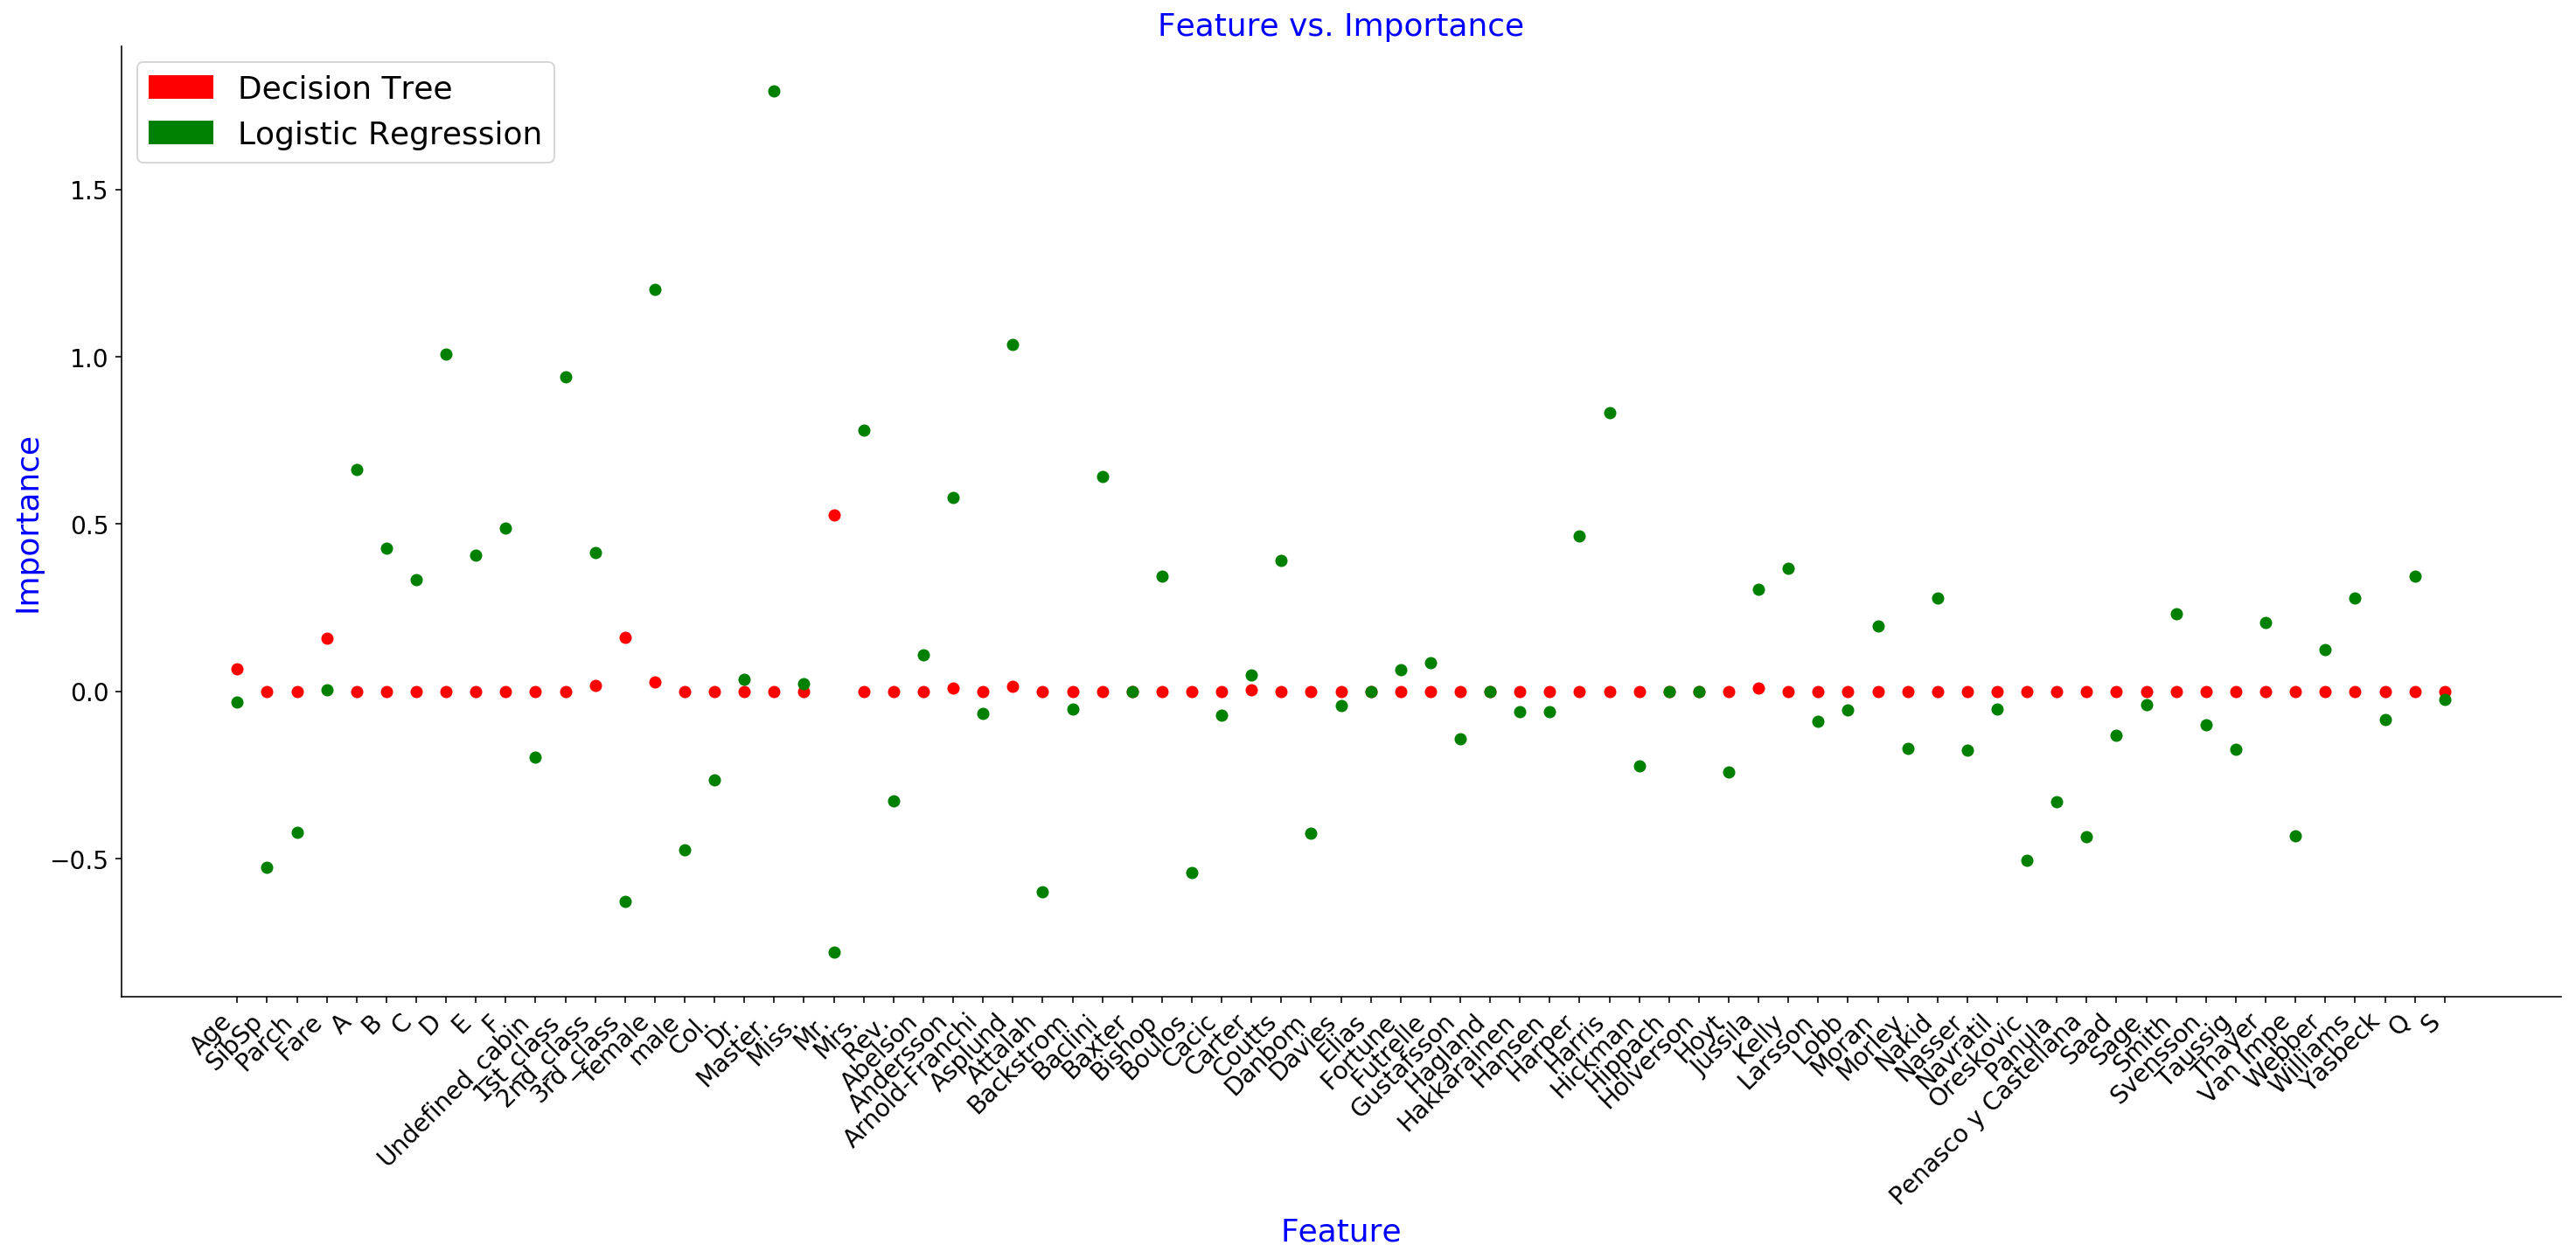

In [209]:
plot_scatter_feature_importance(df_importance, df_logreg_importance)

Logistic Regression gives every feature a non-zero value whereas Decision Trees gives weight to only a few of the features. The Logistic Regression algorithm, through the running of Maximum Likelihood Estimate to minimize a cost function, imposes linearity on the coefficients of the features. 

Decision Trees greedily split on purity of the Gini coefficient, so the resulting feature importance would be biased towards features that yield high purity after the split. The features that do not result in splits have no weightage in the model. 

Thus, the feature importance in the decision tree is directly related to the number of nodes and the max_depth of the tree. Since I have set the max_depth to 4, this limited the amount of features that could appear in the tree's splits. Therefore, most of the features in the dataset by zero for their importance weightage.

Age, Fare, 3rd Class, and 'Mr.' are among the features with nonzero weightage. If I used the overfitted tree from part 2.1, all the features would have nonzero weights. Still, the highest weight will be given to the first split in the decision tree. In this case, that first split is on 'Mr.'.

In Logistic Regression, the most important features were 'Miss', 'female', and 'Cabin Floor E'.

### 2.5 (Extra Credit): Implement a Decision Tree in Python

For extra credit, put away the canned algorithm from sklearn, and write your own decision tree algorithm. Use the simple recursive algorithm we described in class, and use your algorithm to re-do the analysis in 2.1. Do not worry about implementing bells and whistles. However, you will definitely need the following:
 * A "BuildTree" function that implements the recursive algorithm
 * A function to calculate information gain
 
For this problem, you can consult the internets to see how other have done this. However, you must make your code your own - do not plagiarize the examples of other peoples. Implement the minimum required code to build a decision tree

In [210]:
# Enter your code here

*Enter your observations here*

## Part 3: Putting together the pieces 

Over the past two months, you have learned the nuts and bolts of a large number of machine learning algorithms. This list includes: 
* Linear Regression
* Logistic Regression
* LASSO / Ridge Regression
* Support Vector Machines
* Nearest Neighbor
* k-Nearest Neighbors
* Naive Bayes
* Decision Trees
* Regression Trees
* Random Forests
* Boosted trees
* Perceptrons
* Neural Networks

Here, you will explore how well different algorithms can predict survival on the Titanic.


### 3.1 Horseraces

In addition to logistic regression and the single decision tree, use the following algorithms to predict survival: LASSO regression, k-Nearest Neighbors, [random forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), a [multi-layer perceptron](http://scikit-learn.org/stable/modules/neural_networks_supervised.html) and [Gradient Boosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). Make sure everything you do is carefully cross-validated, and that you are providing the same data to each algorithm, in a sensible way.

Create a barplot that shows how well each algorithm compares relative to the others, separately for the training and testing datsets. Define "performance" in the way you think is most appropriate for this problem, and justify that decision. What algorithm performs best?

*Note:* You might want to consider more than one measures of performance

In [222]:
def cv_all_models(models, verbose=True):
    ''' Lasso regression, kNN, random forest, MLP, Gradient Boosting'''
    kf = KFold(n_splits=10, random_state=789, shuffle=False)
    train_arr = np.asarray(train_features_final)
    test_arr = np.asarray(test_features_final)
    test_labels_arr = np.asarray(test_labels)
    train_labels_arr = np.asarray(train_labels)

    fold = 0
    folds = []
    df = []
    # for 3.2
    preds_test_all_models = []
    for model in models:
        model_ = model[0]
        name = model[1]
        test_accuracies = []
        train_accuracies = []
        preds_test_in_model = []
        tests = []
        test_labels_all_models = []
        for train_index, test_index in kf.split(train_arr):
            fold += 1
            folds.append(fold)
            train_features, test_features = train_arr[train_index], train_arr[test_index]
            train_label, test_label = train_labels_arr[train_index], train_labels_arr[test_index]

            # Run Cross-Validation here
            fitted = model_.fit(train_features, train_label)
            preds_train = fitted.predict(train_features)
            preds_test = fitted.predict(test_features)
            preds_test_in_model.append(preds_test)
            test_accuracy = accuracy_score(preds_test, test_label.ravel())
            tests.append(test_label)
            train_accuracy = accuracy_score(preds_train, train_label.ravel())
            test_accuracies.append(test_accuracy)
            train_accuracies.append(train_accuracy)
        avg_train_accuracy = np.mean(train_accuracies)
        avg_test_accuracy = np.mean(test_accuracies)
        max_test_accuracy = max(test_accuracies)
        max_train_accuracy = max(train_accuracies)
        index_of_best_test = test_accuracies.index(max_test_accuracy)
        index_of_best_train = train_accuracies.index(max_train_accuracy)
        best_test_accuracy = test_accuracies[index_of_best_test]
        best_train_accuracy = train_accuracies[index_of_best_train]
        preds_of_best_test = preds_test_in_model[index_of_best_test]
        corresponding_test_labels = tests[index_of_best_test]
        preds_test_all_models.append(preds_of_best_test)
        test_labels_all_models.append(corresponding_test_labels)
        df.append((name, avg_train_accuracy, avg_test_accuracy, best_train_accuracy, best_test_accuracy))
        if verbose:
            print('Average training accuracy for the {} model is {}.'.format(name, avg_train_accuracy))
            print('Average test accuracy for the {} model is {}.'.format(name, avg_test_accuracy))
    columns = ['Model Name', 'Average Train Accuracy', 'Average Test Accuracy',
              'Best in-fold Train Accuracy', 'Best in-fold Test Accuracy']
    df = pd.DataFrame(df, columns=columns)
    return df, preds_test_all_models, test_labels_all_models

def prepare_models():
    models = []
    # Lasso - logreg with L1 normalization
    lasso = LogisticRegression(penalty='l1')
    models.append((lasso, 'LASSO'))
    # kNN
    knn = KNeighborsClassifier()
    models.append((knn, 'kNN'))
    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=20)
    models.append((rf, 'Random Forest'))
    # MLP
    mlp = MLPClassifier()
    models.append((mlp, 'Multilayer Perceptron'))
    # Gradient Boosting
    grad_boost = GradientBoostingClassifier(max_depth=4)
    models.append((grad_boost, 'Gradient Boosting'))
    return models

In [223]:
prepared_models = prepare_models()
df_compare_models, preds_test, test_labels_all = cv_all_models(prepared_models, verbose=False)
df_compare_models.sort_values('Average Test Accuracy')

,Model Name,Average Train Accuracy,Average Test Accuracy,Best in-fold Train Accuracy,Best in-fold Test Accuracy
1,kNN,0.793070,0.723298,0.808112,0.791667
3,Multilayer Perceptron,0.790567,0.766901,0.834633,0.845070
0,LASSO,0.824439,0.810407,0.829953,0.845070
2,Random Forest,0.859706,0.813146,0.868955,0.861111
4,Gradient Boosting,0.927435,0.822966,0.936037,0.873239


From the summary dataframe, you can see that Gradient Boosting has the highest average test accuracy at 83.3%. Then comes Random Forest at 81.6%.

The same ranking occurs for Average Train, Average Test, and Best in-fold Train accuracies. However, for the best in-fold Test Accuracy, the Random Forest is the leader at 90.14%.

### 3.2 Error analysis

Perform some error analysis to gain some intuition for where your models are not performing well. Are your models all having problems with the same individuals? Inspect this manually and report your results.

Now, do this a bit more systematically by creating a correlation matrix showing the correlation in predictions between each model. In other words, treat the output of each of your *M* models as a binary vector with one entry for each of the test data, and show how these prediction vectors relate to each other by plotting the *M* x *M* matrix of correlation coefficients. What do you observe?

### First the confusion matrix:

In [224]:
def plot_confusion_matrix(cm, labels,
                          title='Confusion matrix',
                         cmap=None):
    
    plt.figure(figsize=(8,8))

    sns.heatmap(cm,
               annot=True,
               fmt='d',
               linewidths=0.5,
               cmap=cmap)
    
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

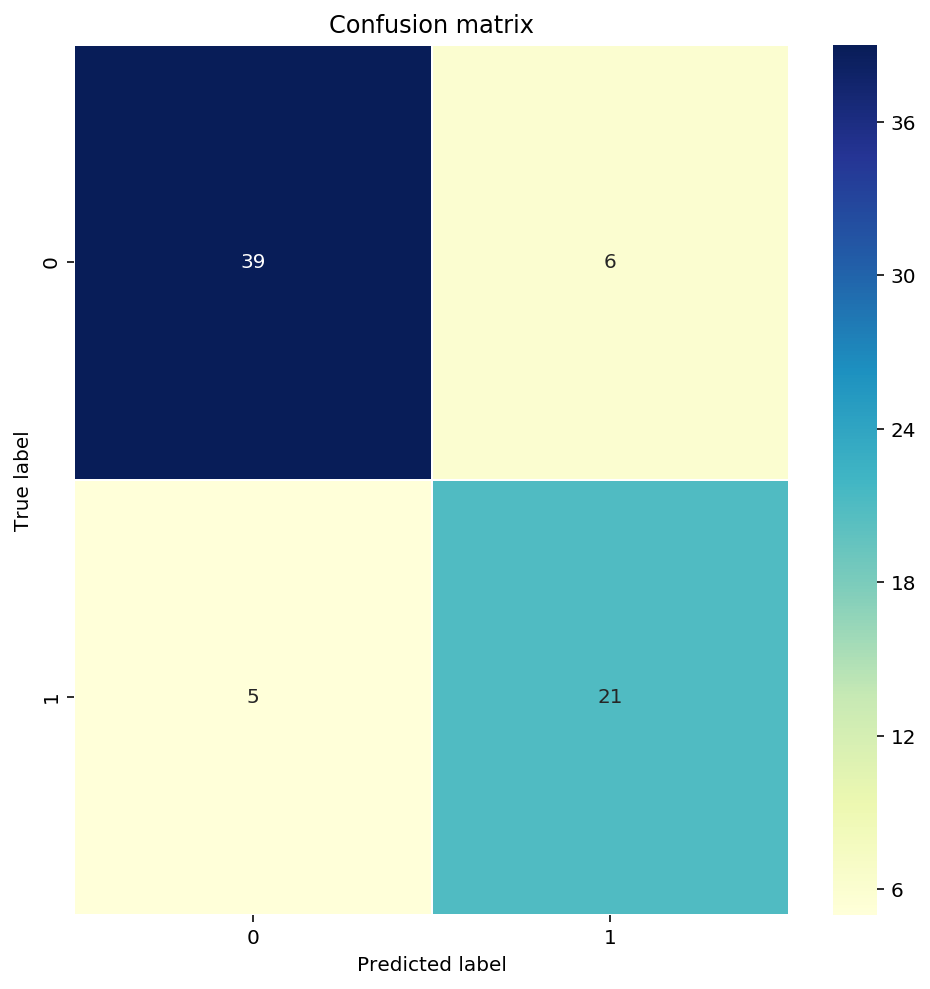

In [225]:
if len(test_labels_all[0]) > len(preds_test[0]):
    lab = test_labels_all[0][:-1]
    preds_t = preds_test[0]
elif len(test_labels_all[0]) < len(preds_test[0]):
    preds_t = preds_test[0][:-1]
    lab = test_labels_all[0]
else:
    lab = test_labels_all[0]
    preds_t = preds_test[0]
cm = confusion_matrix(lab, preds_t)
plot_confusion_matrix(cm, 
                     labels=['Died','Survived'],
                     cmap="YlGnBu")

So in the best in-fold accuracy on the test set for my Logistic Regression, I get 5 'survived' people that were misclassified as 'dead' and 6 'dead' people that were misclassified as 'survived'. Note, these numbers will vary if you rerun the functions above. This confusion matrix takes the cross-validated run of Logistic Regression that has the best accuracy on the test set.

In [226]:
# Enter your code here
m1, m2, m3, m4, m5 = list(tuple(preds_test))
m2, m5 = m2[:-1], m5[:-1]

In [227]:
def plot_correlation_matrices1(preds_test):
    m1, m2, m3, m4, m5 = tuple(preds_test)
    m2, m5 = m2[:-1], m5[:-1]
    five_choose_two = 10
    pairs = [(m1,m2), (m1,m3), (m1,m4), (m1,m5),
            (m2,m3), (m2,m4), (m2,m5), (m3,m4),
            (m3,m5), (m4,m5)]
    # correlation matrix 
    for pair in pairs:
        m1, m2 = pair
        fig, axes = plt.subplots(figsize=(3,3))
        corrs = np.corrcoef(m1, m2)
        sns.heatmap(corrs, xticklabels=list(range(len(corrs))),yticklabels=list(range(len(corrs))),
                    annot=True)

In [228]:
def plot_correlation_matrices2(preds_test):

    m1, m2, m3, m4, m5 = tuple(preds_test)
    m2, m5 = m2[:-1], m5[:-1]
    df = [tuple(m1), tuple(m2), tuple(m3), tuple(m4), tuple(m5)]
    df = pd.DataFrame(df)
    # correlation matrix 
    fig, axes = plt.subplots(figsize=(20,20))
    corrs = df.corr()
    sns.heatmap(corrs, xticklabels=list(range(len(corrs))),yticklabels=list(range(len(corrs))))

In [229]:
def plot_correlation_matrices3(preds_test):
    ''' 
        m1 = Lasso regression, 
        m2 = kNN, 
        m3 = random forest, 
        m4 = MLP, 
        m5 = Gradient Boosting
    '''
    m1, m2, m3, m4, m5 = tuple(preds_test)
    m2, m5 = m2[:-1], m5[:-1]
    five_choose_two = 10
    pairs = [(m1,m2), (m1,m3), (m1,m4), (m1,m5),
            (m2,m3), (m2,m4), (m2,m5), (m3,m4),
            (m3,m5), (m4,m5)]
    titles = ['Lasso and kNN', 'Lasso and Random Forest',
             'Lasso and MLP', 'Lasso and Gradient Boosting',
             'kNN and Random Forest', 'kNN and MLP', 'kNN and Gradient Boosting',
            'Random Forest and MLP', 'Random Forest and Gradient Boosting',
             'MLP and Gradient Boosting']
    # correlation matrix 
    i = -1
    for pair in pairs:
        i += 1
        print(titles[i])
        m1, m2 = pair
        df = [tuple(m1), tuple(m2)]
        df = pd.DataFrame(df)
        fig, axes = plt.subplots(figsize=(10,10))
        corrs = df.corr()
        sns.heatmap(corrs, xticklabels=list(range(len(corrs))),yticklabels=list(range(len(corrs))),
                    annot=True)

Lasso and kNN
Lasso and Random Forest
Lasso and MLP
Lasso and Gradient Boosting
kNN and Random Forest
kNN and MLP
kNN and Gradient Boosting
Random Forest and MLP
Random Forest and Gradient Boosting
MLP and Gradient Boosting


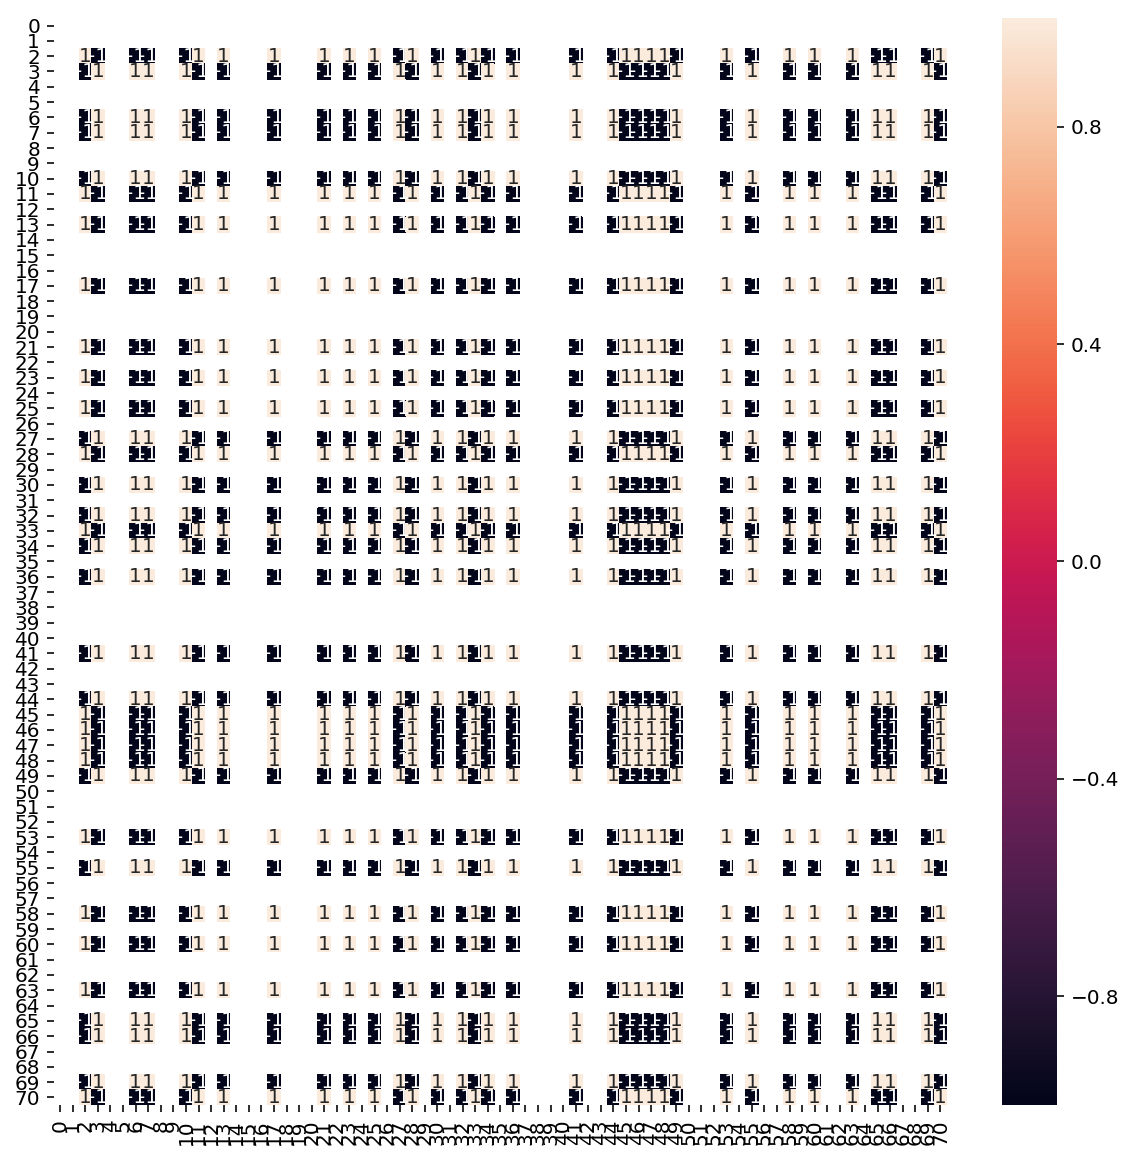

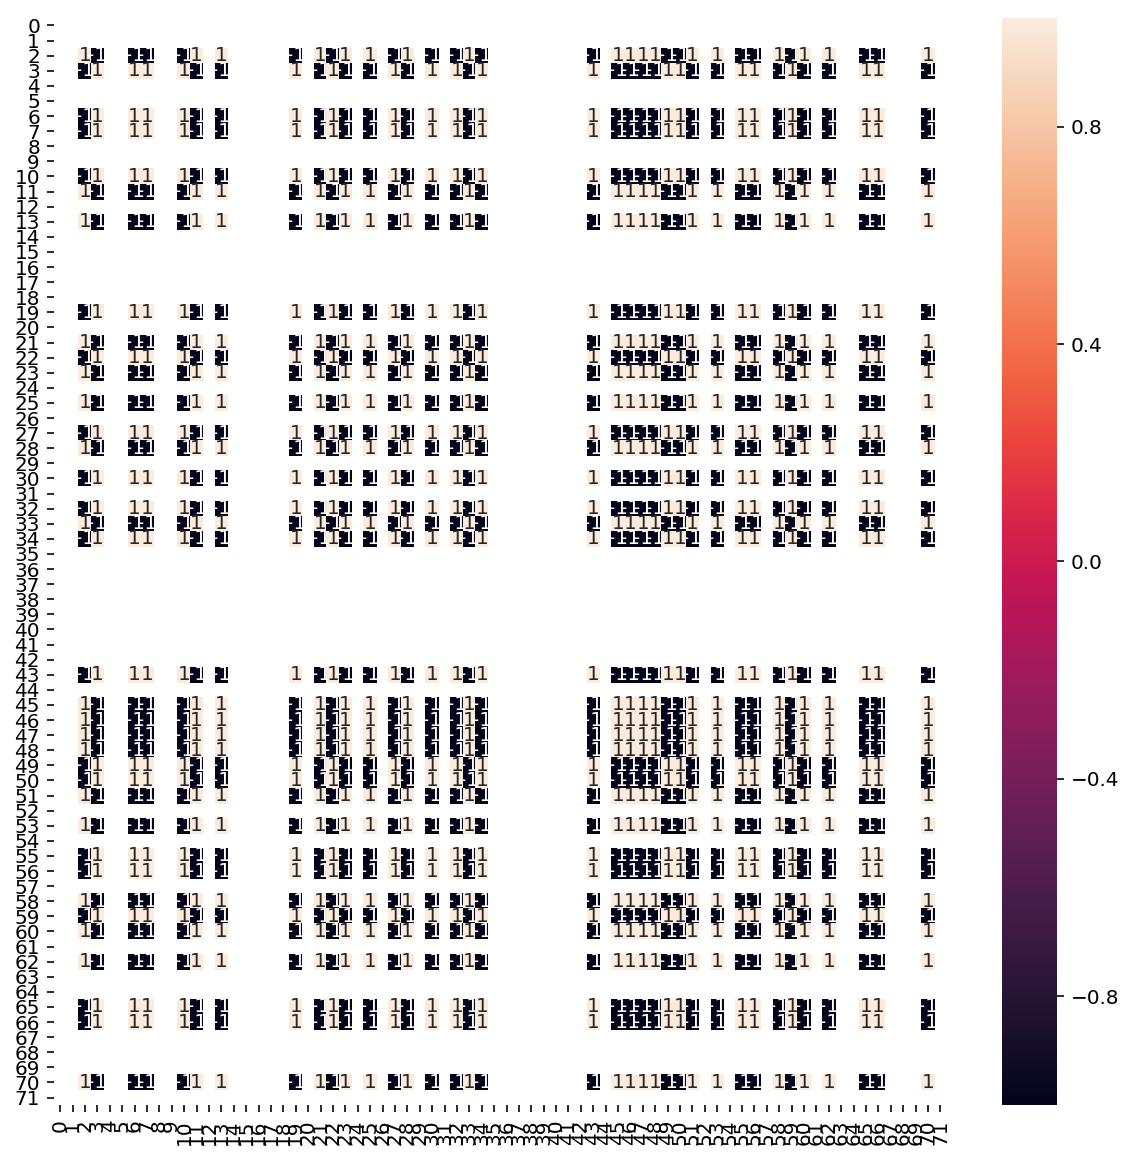

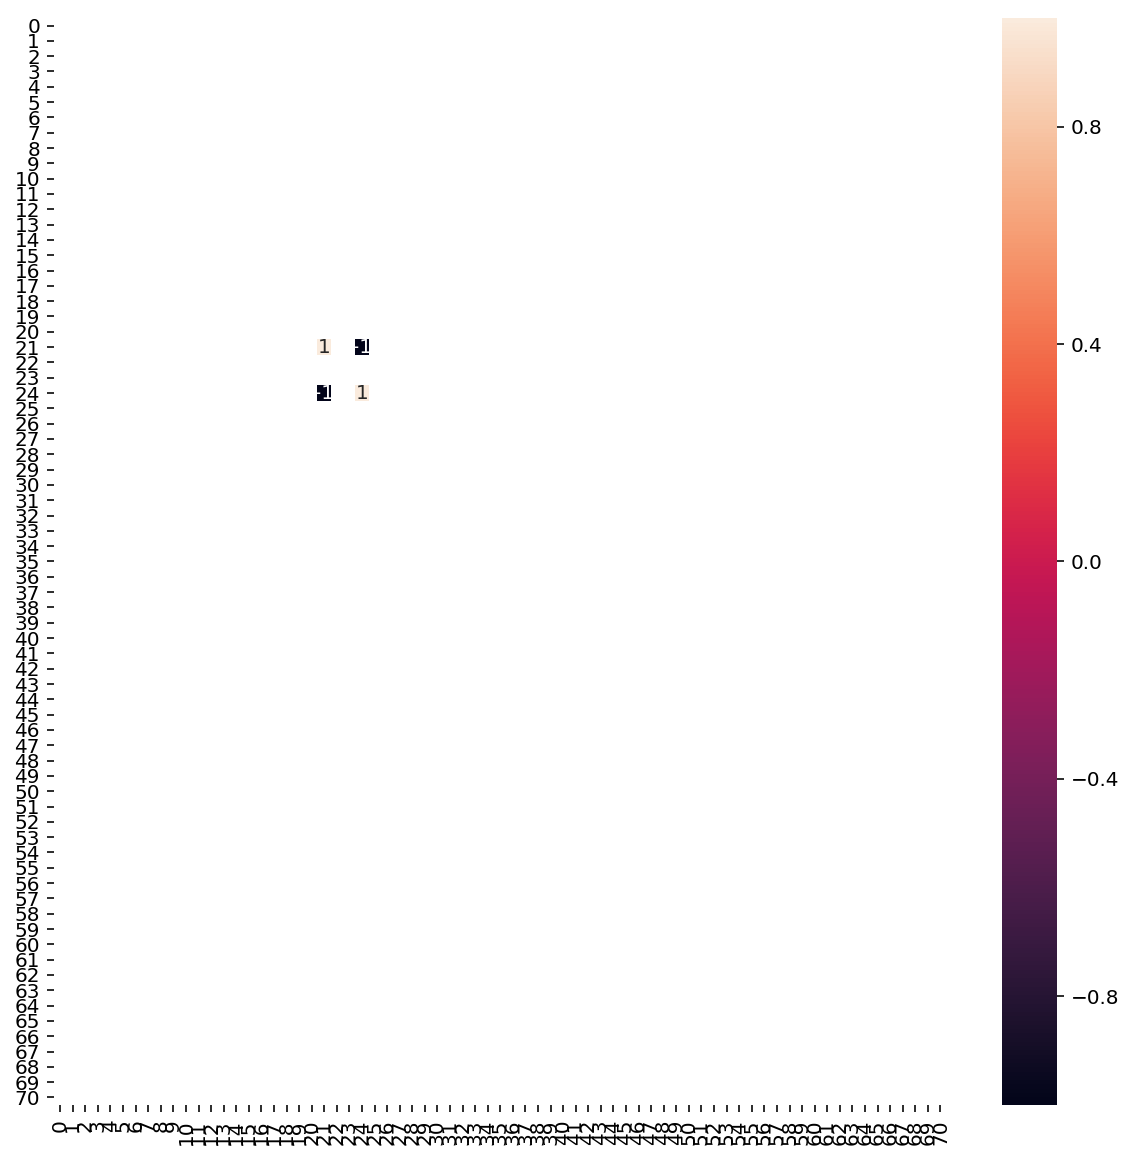

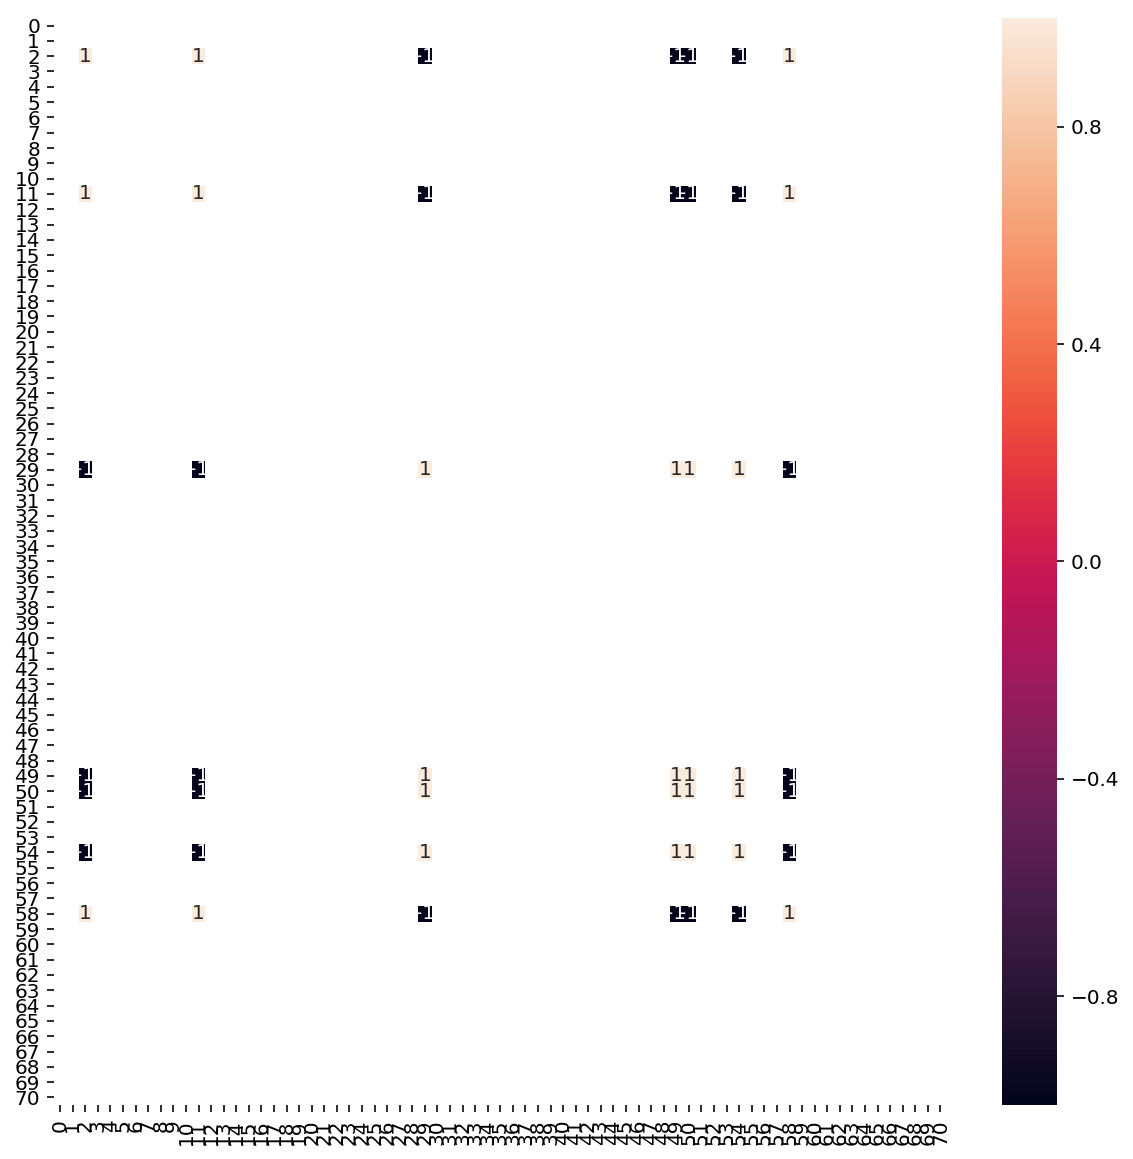

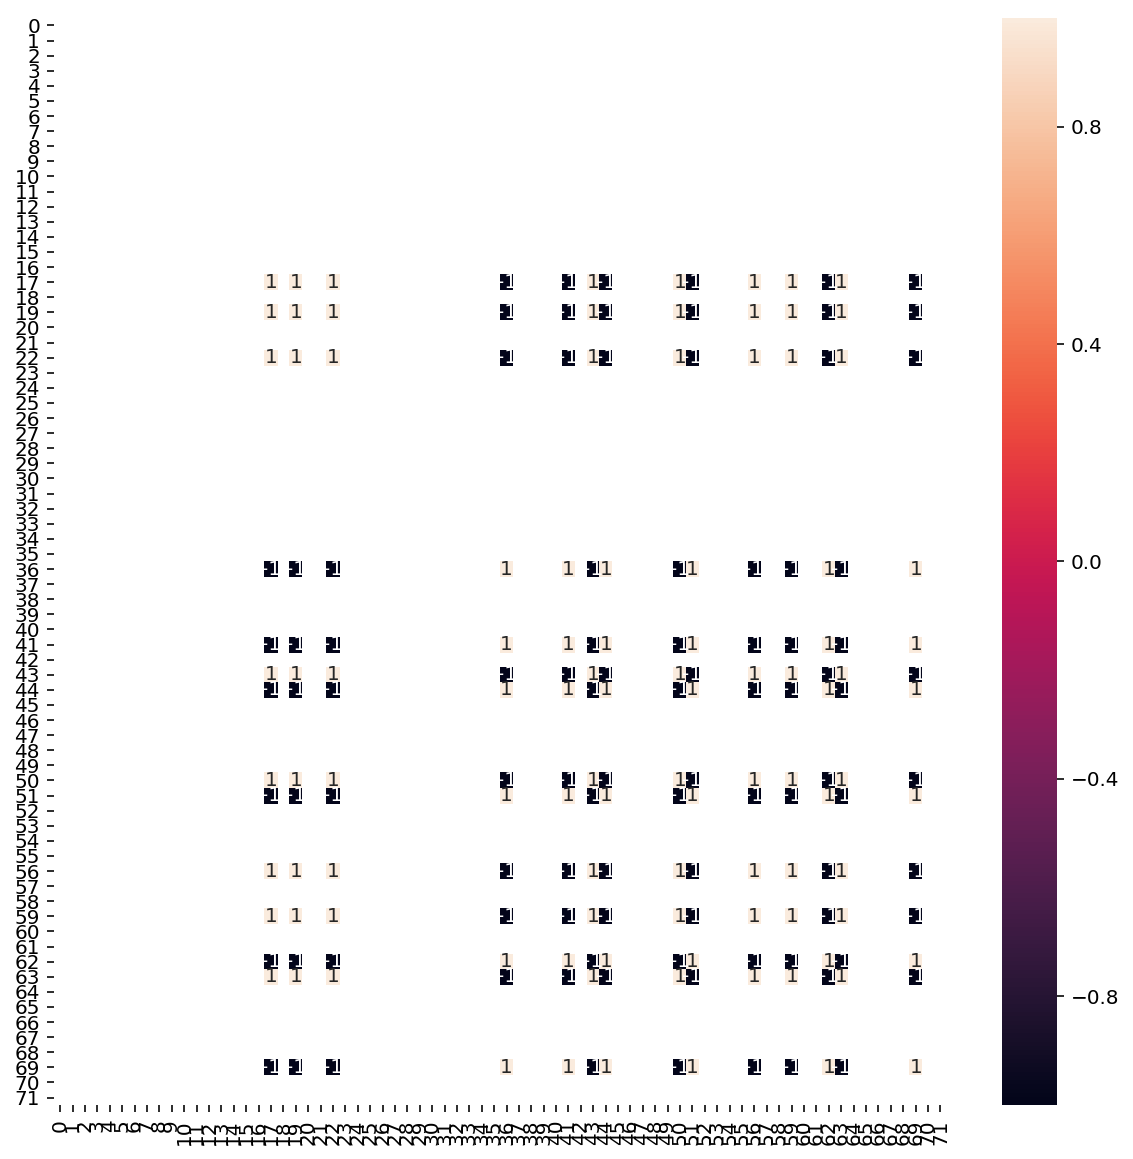

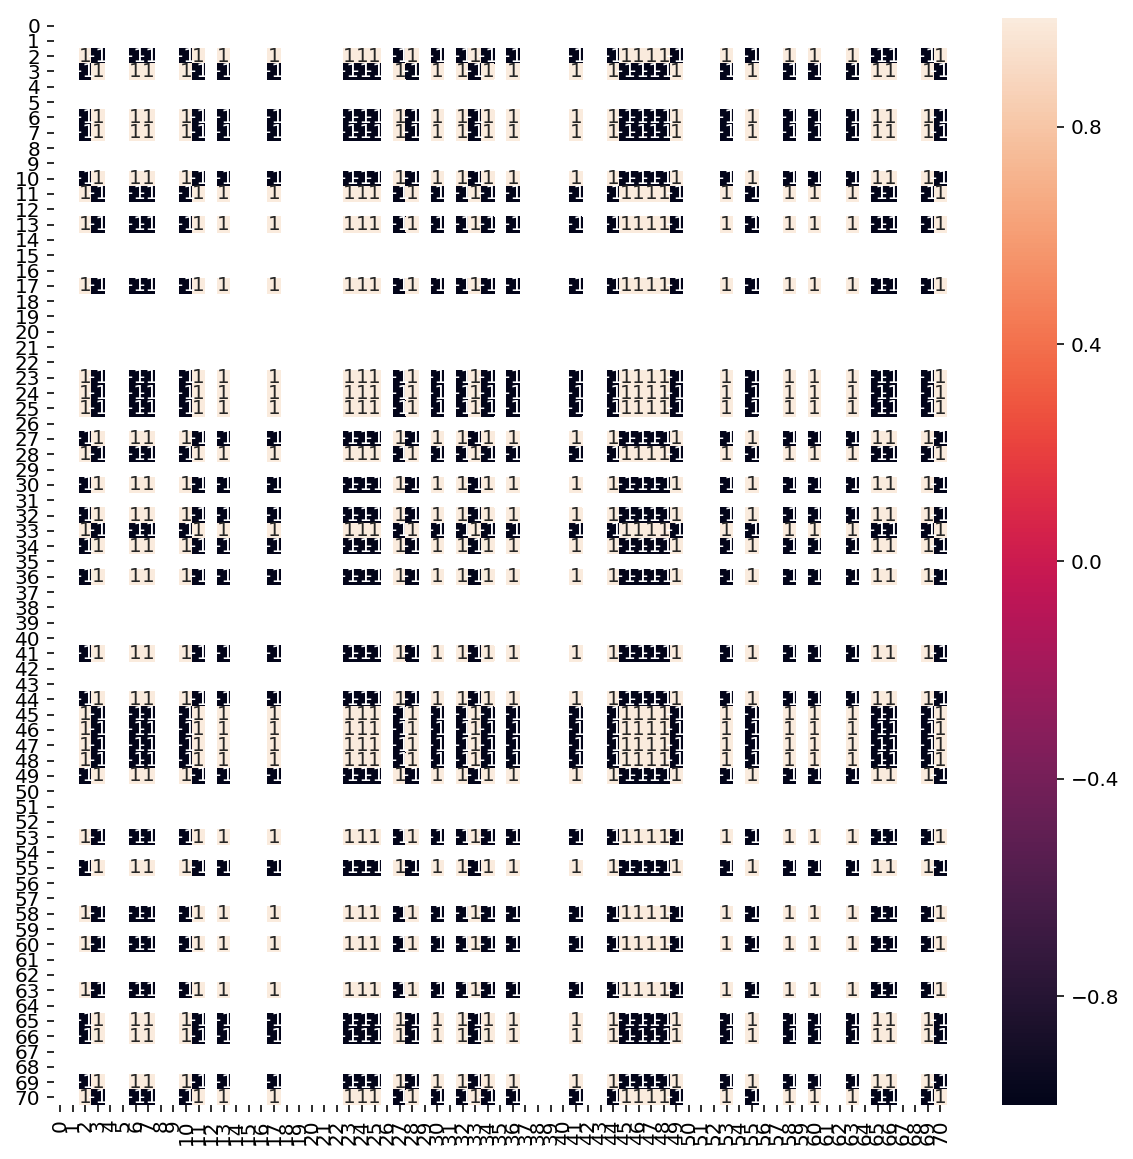

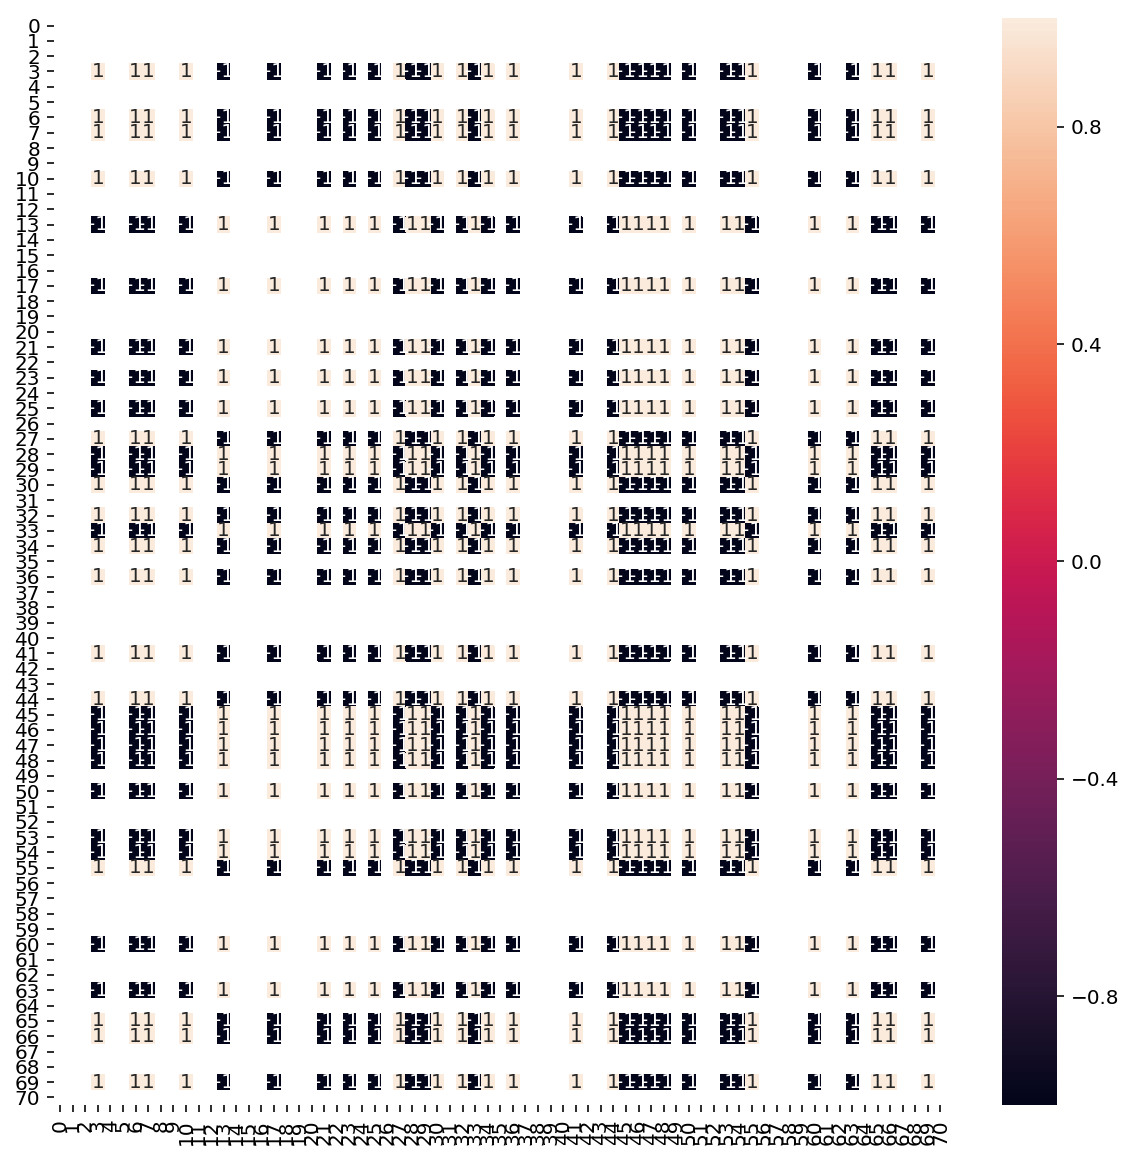

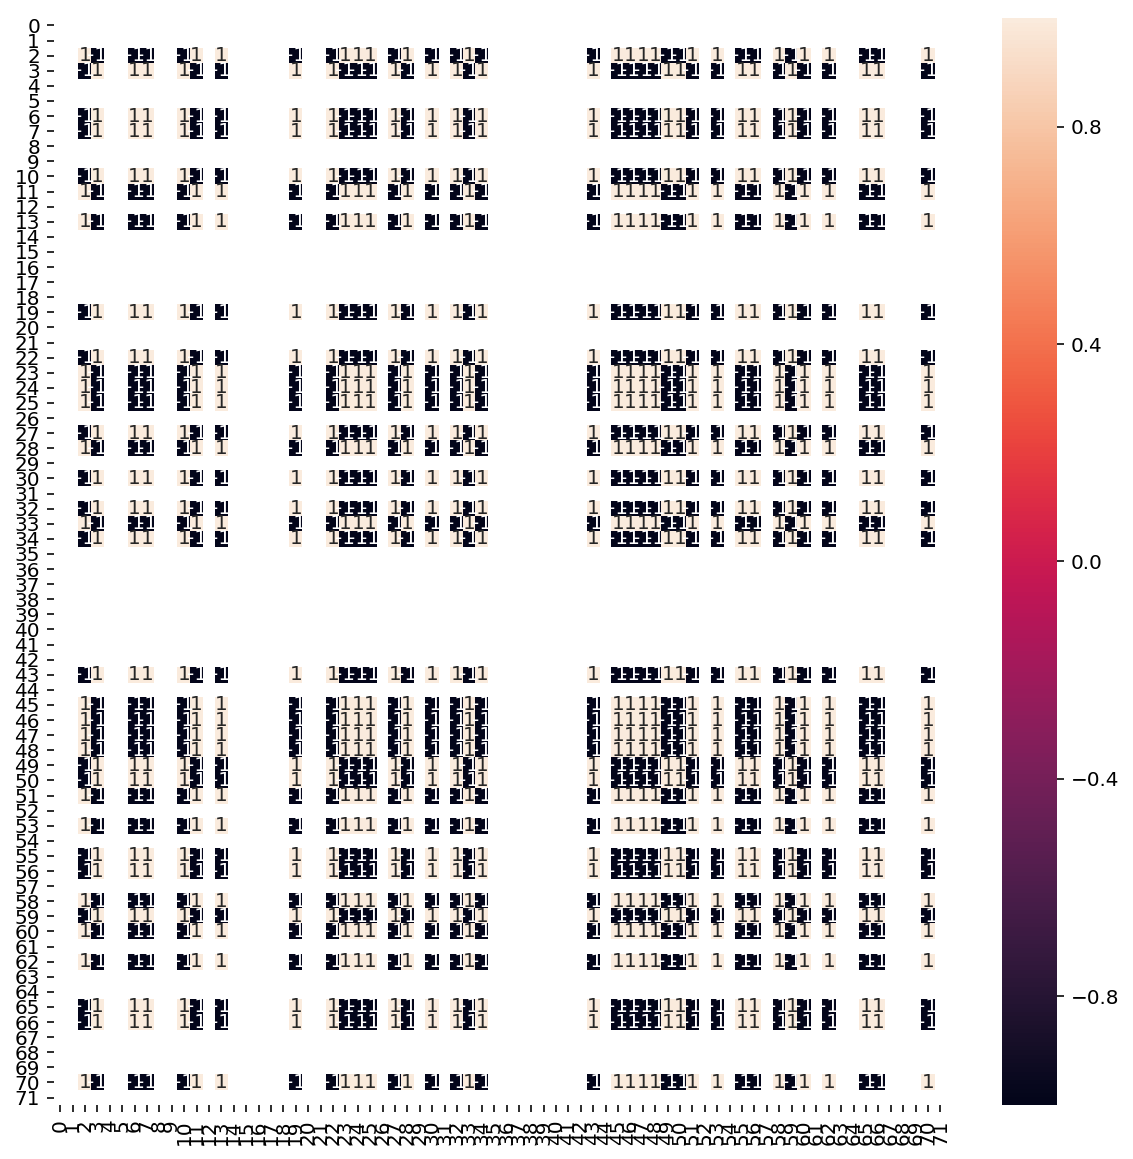

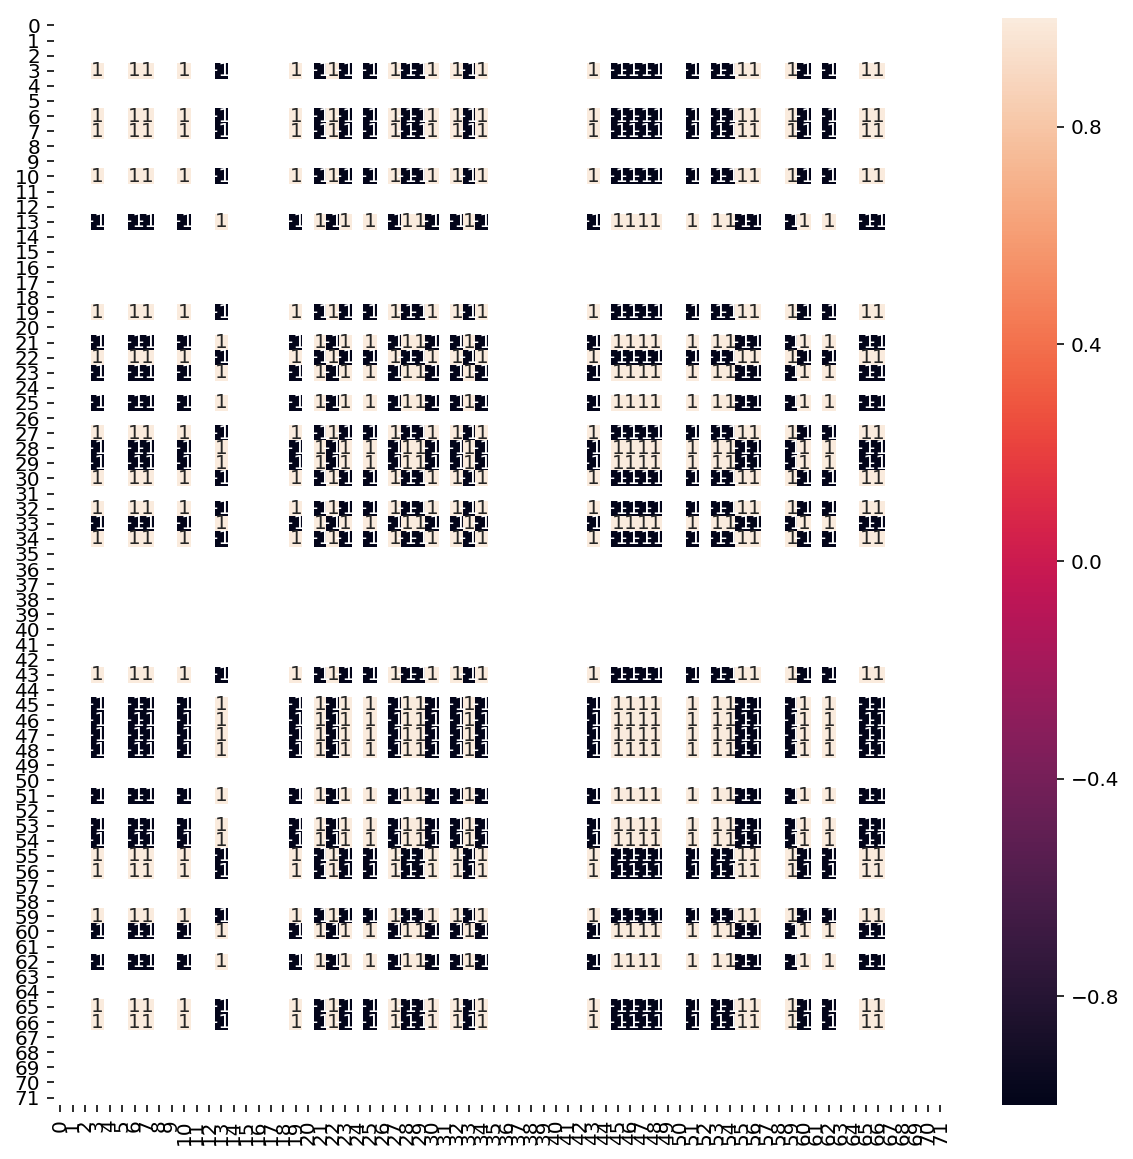

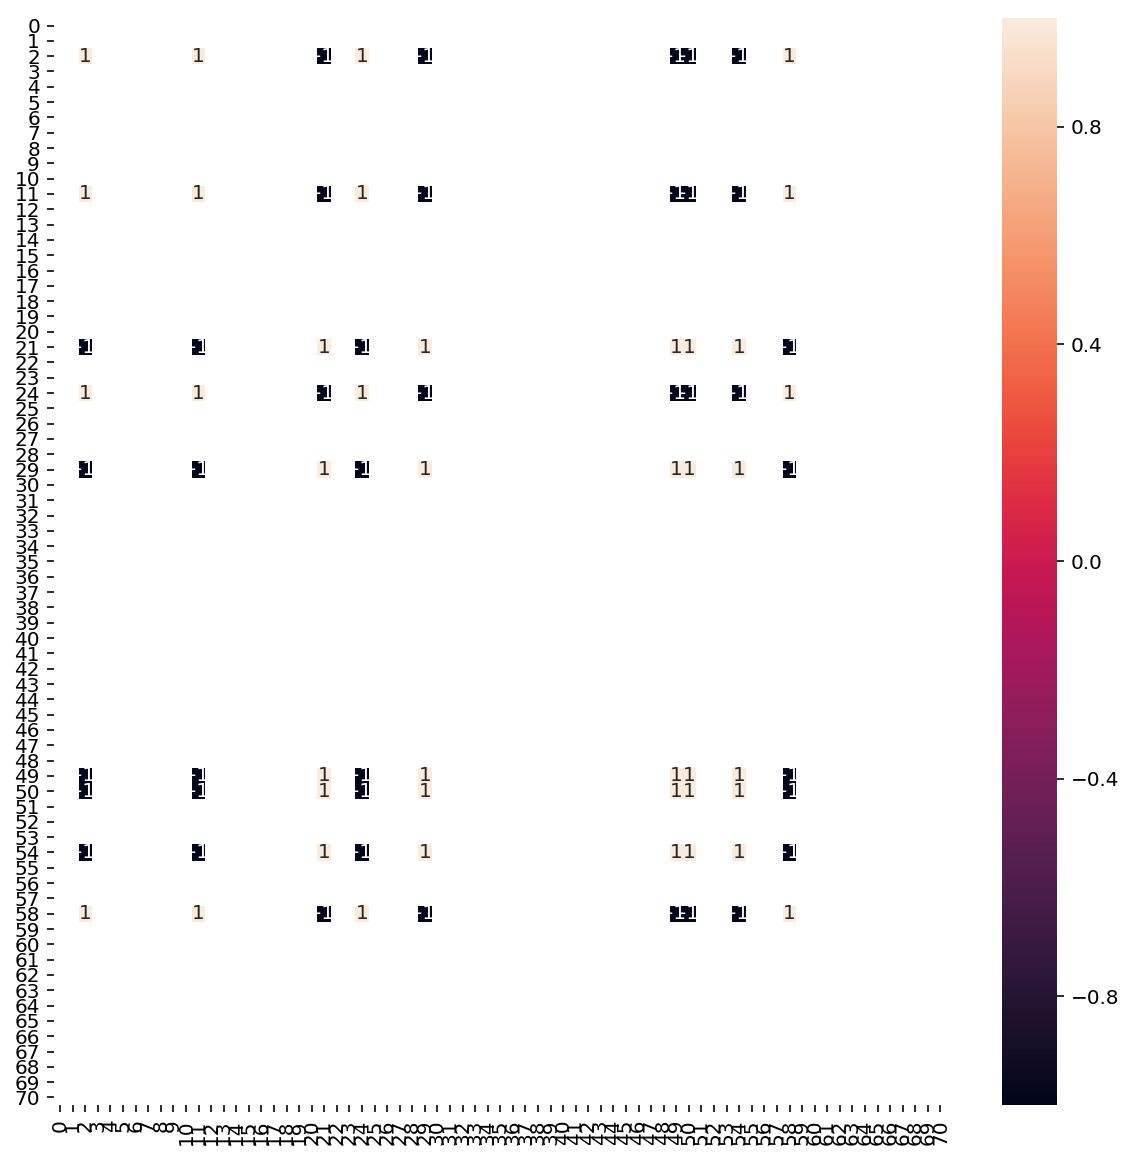

In [230]:
plot_correlation_matrices3(preds_test)

The nonlinear methods are highly correlated, the ensemble methods are highly correlated, and the linear methods are highly correlated. For example, MLP, kNN, and Random Forest (which is based on Decision Trees) are all nonlinear methods that are correlated. 

The Lasso regression is not correlated with kNN. This makes sense because Lasso regression searches for a linear boundary while kNN searches for a nonlinear boundary.

In fact, kNN is not correlated with any of the models--MLP, Random Forest, or Gradient Boosting. This may be because there is no definitive clustering the data given my featureset. So kNN does not result in an accurate prediction.

### 3.3 Develop an ensemble

Create an ensemble learner by hand. Using all of the training data, fit each of the models in 3.1. Then, classify each instance in the test data by taking the majority vote of all of your different fitted models. How accurately do you predict survival? How does this compare to your earlier results? 

*Note:* You will have to decide how to handle tie votes

In [231]:
# Enter your code here
def run_model_preds(model, train_features, train_labels, test_features, test_labels, verbose=True):
    if verbose:
        print()
        print('Training the model (Fitting to the training data) ')
    model_, name = model
    fitted = model_.fit(train_features, train_labels)
    if verbose:
        print('Fitted model: {}'.format(fitted))
        print('Test the model.')
    predicted = fitted.predict(test_features)
    predicted_classes = predicted.round()
#     accuracy = accuracy_score(predicted_classes, test_labels)
#     #fscore = f1_score(predicted_classes, test_labels, average='weighted')
#     if verbose:
#         print('This model\'s accuracy is {}'.format(accuracy))
#     #print('This model\'s f1 score is {}'.format(fscore))
    return fitted, predicted_classes

def run_all_models(prepared_models, verbose=True):
    df_preds = []
    for model in prepared_models:
        fitted, preds = run_model_preds(model, train_features_final, train_labels, test_features_final, test_labels,
                                 verbose=verbose)
        df_preds.append(preds)
    df_preds = pd.DataFrame(df_preds)
    return df_preds

In [232]:
df_votes = run_all_models(prepared_models, verbose=False)

**I used the mode function to implement the majority vote across all models**

In [233]:
majority_vote = df_votes.mode().transpose()

In [234]:
maj_vote_accuracy = accuracy_score(majority_vote, test_labels)
maj_vote_accuracy

0.86033519553072624

For the Majority Vote accuracy, I got 86.0%

### 3.4 What can we learn from the models?

Revisit your analysis from in part 1.2, now that you have deployed several machine learning models on the task of predicting survival. For each of the models that you fitted in 3.1, do your best to interpret the model itself, and summarize what the model tells you about the factors that were most important in determining survival on the Titanic. Are all of the models telling you the same thing, or do different models suggest different explanations?

Logistic Regression uses Maximum Likelihood Estimate to minimize a cost function. This provides an even spread for their coefficients. It also assumes that the data inherently has a linear decision boundary, which may or may not be correct. This linearity, through MLE, imposes coefficients on features which may not be correct if the data requires nonlinear decision boundaries. 

In Logistic Regression, the most important features were 'Miss', 'female', and 'Cabin Floor E'.

Decision Trees greedily split on purity of the Gini coefficient, so the resulting feature importance would be biased towards features that yield high purity after the split. Like Decision Trees, other tree models such as Random Forest and Gradient Boosting, have a similar interpretation for feature importance. Features are used to cause purity in nodes according to the Gini coefficient. This would yield biased feature importance because it is a greedy algorithm. However, it works well if the actual data has nonlinear decision boundaries.

For Decision Trees, the most important features were Age, Fare, 3rd Class, and 'Mr.' The first split is on 'Mr.'.

MLP is hard to interpret, because it goes through many layers of nonlinear transformations, during both forward and backward propogation. In this case, MLP has RELU activation function, which introduces the nonlinear step function to each output of each layer. The featuresets in MLP get heavily transformed in each iteration of the neural network, so the resulting output is hard to interpret. However, MLP yields the 3rd highest accuracy.

For kNN, it was not very interpretable. One explanation is because there were no clear clusters that formed from my representation of the featureset. For further research, I might try to visualize the clusters that form from my featureset and see if I get any insights.